# NNSAE on FashionMNIST Dataset
Online learning and generalization of parts-based image representations by Non-Negative Sparse Autoencoders from Lemme et al. (2011).
* Dimension of the encoding : 100
* Shallow Encoder and Decoder with tied weights $W_E = W_D^T$ 
* Sparsity of the encoding enforced with Intrinsic Plasticity:
    * Learning rate for synaptic plasticity of the read-out layer : lrateRO = 0.01
    * Learning rate for intrinsic plasticity : lrateIP = 0.001
* Non-Negativity of the weigths enforced with asymetric weight decay (no decay on positive weights) 
* In the original paper, the data is scaled by multiplying it by 0.25, but MNIST was between 0 and 255 while FashionMNIST is already between 0 and 1. So I removed the scaling from this notebook as it did not affect the visual quality of the reconstruction and of the max_approximation. Note as well that is did not affect the measured sparsity of the encoding.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../SourceCode')
import bastien_utils
import datetime
import morphoMaths
import pandas as pd
from scipy import io
import metrics

Using TensorFlow backend.


In [2]:
#Loading FashionMNIST
FILE_PATH = "../"
x_test, y_test = bastien_utils.load_data_fashionMNIST(FILE_PATH, train=False, test=True, subsetTest=False)
idx_small = np.arange(10)
idx_small[2]=31
x_small = x_test[idx_small]
print('x_small shape:', x_small.shape)
print('x_test shape:', x_test.shape)

x_small shape: (10, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [3]:
#Loading the encodings, reconstructions and atoms from NNSAE
h_test = io.loadmat("../Results/NNSAE/18_11_07_fashion_MNIST_lrateR0_01_lrateIP_001_regR0_0002/Results_NNSAE/h_test.mat")['h_test']
x_rec_test = io.loadmat("../Results/NNSAE/18_11_07_fashion_MNIST_lrateR0_01_lrateIP_001_regR0_0002/Results_NNSAE/x_test_rec.mat")['x_test_rec']
atoms = io.loadmat("../Results/NNSAE/18_11_07_fashion_MNIST_lrateR0_01_lrateIP_001_regR0_0002/Results_NNSAE/W.mat")['W']
x_rec_test = x_rec_test.reshape((10000, 28, 28, 1))
atoms = np.transpose(atoms).reshape((100,28,28,1))
x_rec_small = x_rec_test[idx_small]

(Test) Original images and reconstructions - Reconstruction error:  0.05141151048128018


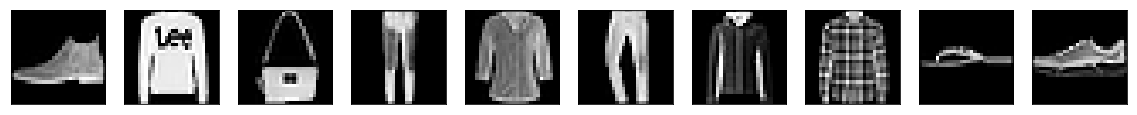

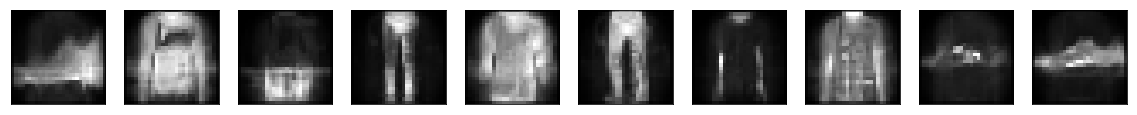

Histograms of the encodings - Sparsity (Hoyer):  0.22032299763251623


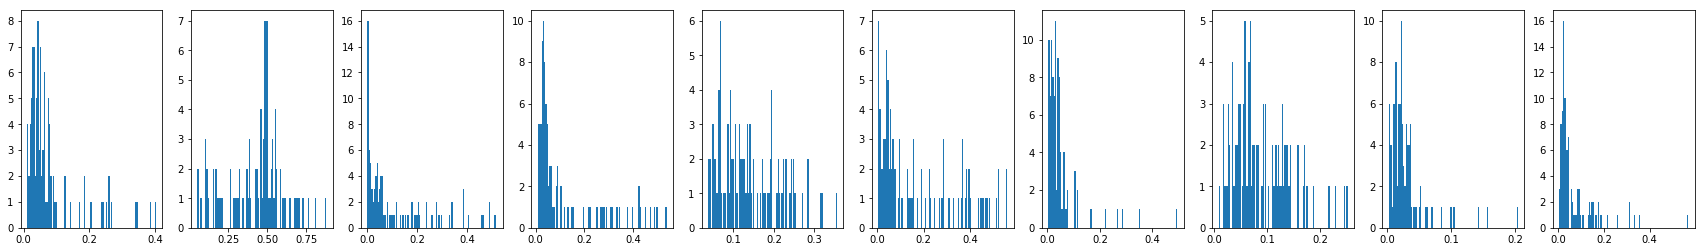

Atom images of the decoder


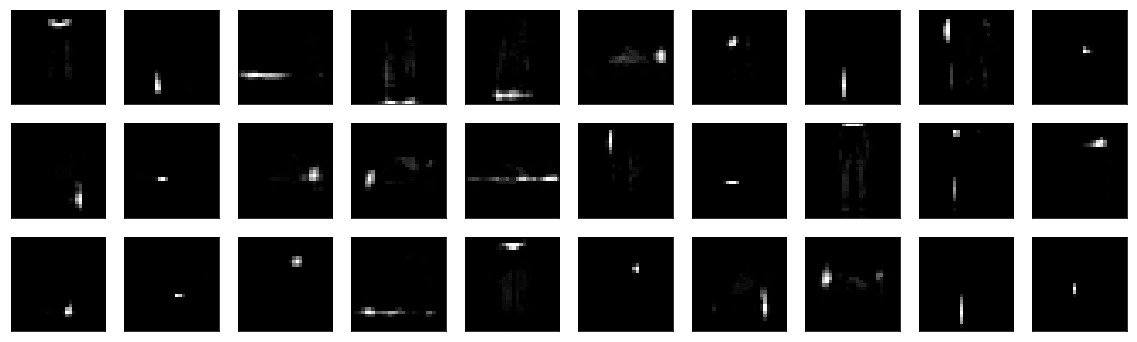

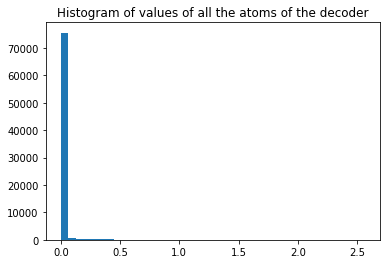

In [4]:
print('(Test) Original images and reconstructions - Reconstruction error: ', metrics.reconstruction_error(x_test, atoms, h_test))
bastien_utils.plot_all_images(x_small)
bastien_utils.plot_all_images(x_rec_small)
print('Histograms of the encodings - Sparsity (Hoyer): ', metrics.sparsity_Hoyer(h_test))
metrics.plot_histograms_of_the_encoding(h_test[idx_small])
print('Atom images of the decoder')
bastien_utils.plot_all_images(atoms[:30])
plt.hist(atoms.flatten(), bins=40)
plt.title('Histogram of values of all the atoms of the decoder')
plt.show()

Dilatation of original images


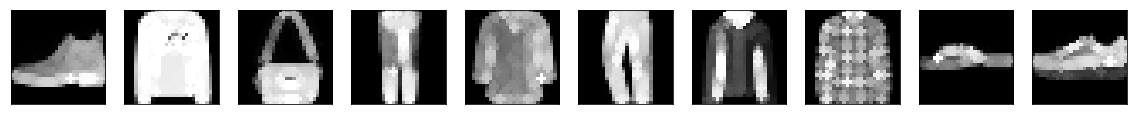

Dilatation of reconstructed images


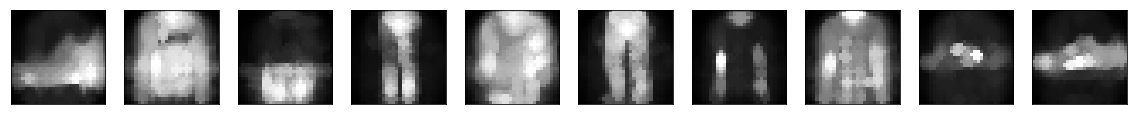

Max-approximation to dilatation
Max-approx error to original:  1.1232448039320557  - Max-approx error to reconstruction:  0.7835567841864489


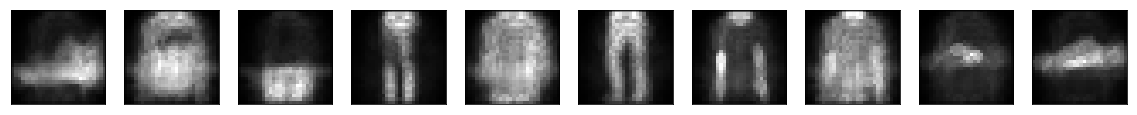

Dilated of the atom images of the decoder


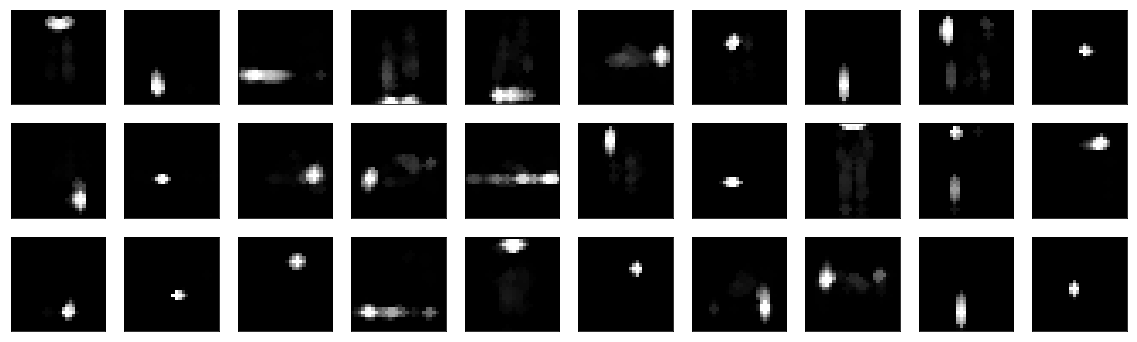

In [9]:
atoms_dil = bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, atoms, SE_scale=1)
max_approx = metrics.max_approximation_error(x_test, atoms, h_test, morphoMaths.dilatation, SE_scale=1)
print('Dilatation of original images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
print('Dilatation of reconstructed images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_rec_small, SE_scale=1))
print('Max-approximation to dilatation')
print('Max-approx error to original: ', max_approx[0], ' - Max-approx error to reconstruction: ', max_approx[1])
bastien_utils.plot_all_images(metrics.reconstructions(atoms_dil, h_test[idx_small]))
print('Dilated of the atom images of the decoder')
bastien_utils.plot_all_images(atoms_dil[:30])

**Question: why a larger max-appox error (than our architecture) with atoms with such small supports ?**

In [7]:
def plot_10_most_used_atoms_for_an_image(h_image, atoms):
    idx_sort = np.flip(np.argsort(h_image))
    major_atoms = atoms[idx_sort[:10]]
    print('Atoms associated with the 10 highest code coefficients of the image')
    bastien_utils.plot_all_images(major_atoms)

Atoms associated with the 10 highest code coefficients of the image


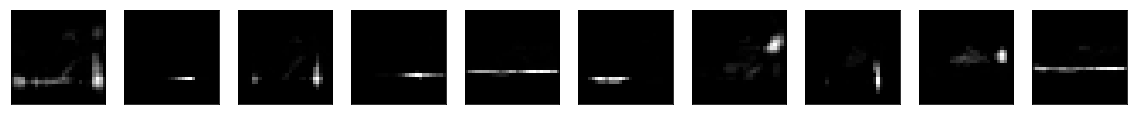

In [12]:
plot_10_most_used_atoms_for_an_image(h_test[0], atoms)

In [34]:
def plot_heat_map_of_overlapping_atoms(h_images, atoms, dilated_atoms=None, number_of_atoms=20, threshold=0.5):
    nb_atoms, nb_rows, nb_columns, _ = atoms.shape
    nb_samples_to_plot = min(h_images.shape[0], 8)
    if dilated_atoms is None:
        show_dilated_atoms = 1
    else:
        show_dilated_atoms = 2
        heat_map_of_dilated_atoms = np.zeros((nb_samples_to_plot,nb_rows, nb_columns))
    heat_map_of_atoms = np.zeros((nb_samples_to_plot,nb_rows, nb_columns))
    for i in range(nb_samples_to_plot):
        idx_sort = np.argsort(h_images[i])
        major_atoms = atoms[idx_sort[-number_of_atoms:],:,:,0]
        binary_atoms = major_atoms.reshape((number_of_atoms, nb_rows*nb_columns))>threshold
        heat_map_of_atoms[i,:,:] = np.sum(binary_atoms, axis=0).reshape((28,28))
        if show_dilated_atoms>1:
            major_atoms = atoms_dil[idx_sort[-number_of_atoms:],:,:,0]
            binary_atoms = major_atoms.reshape((number_of_atoms, nb_rows*nb_columns))>threshold
            heat_map_of_dilated_atoms[i,:,:] = np.sum(binary_atoms, axis=0).reshape((28,28))
    nb_max = max(np.max(heat_map_of_atoms), np.max(heat_map_of_dilated_atoms))
    plt.figure(figsize=(nb_samples_to_plot*3,show_dilated_atoms*3))
    fig, axes = plt.subplots(nrows=show_dilated_atoms, ncols=nb_samples_to_plot, figsize=(nb_samples_to_plot*2, show_dilated_atoms*2))
    i = 0
    for ax in axes.flat:
        ax.set_axis_off()
        if i<nb_samples_to_plot:
            im = ax.imshow(heat_map_of_atoms[i].reshape((nb_rows,nb_columns)), cmap='hot', vmin=0, vmax=nb_max)    
        if i>=nb_samples_to_plot:
            im = ax.imshow(heat_map_of_dilated_atoms[i-nb_samples_to_plot].reshape((nb_rows,nb_columns)), cmap='hot', vmin=0, vmax=nb_max)    
        i += 1
    cb_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)
    plt.show()

<Figure size 1728x432 with 0 Axes>

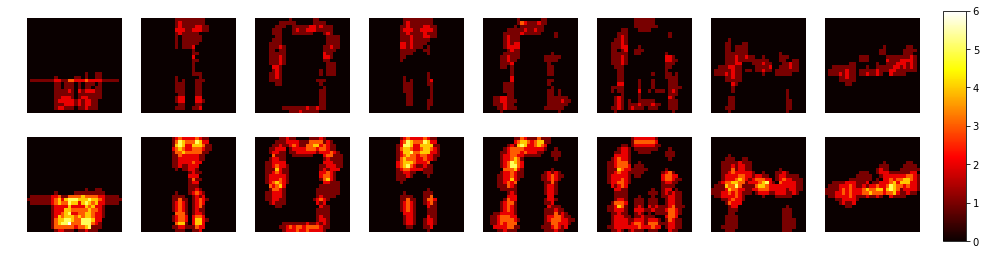

In [35]:
plot_heat_map_of_overlapping_atoms_for_four_images(h_test[idx_small][2:10], atoms, dilated_atoms=atoms_dil,number_of_atoms=20 )

<Figure size 1728x432 with 0 Axes>

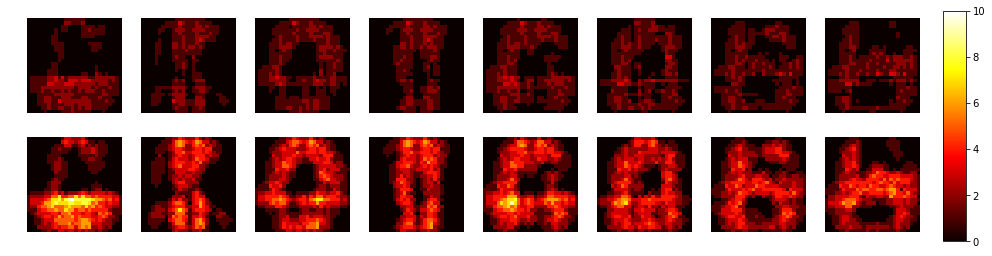

In [55]:
plot_heat_map_of_overlapping_atoms_for_four_images(h_test[idx_small][2:10], atoms, dilated_atoms=atoms_dil,number_of_atoms=50)

In [45]:
def progressive_reconstruction(h_image, atoms, number_of_steps=50):
    nb_atoms, nb_rows, nb_columns, _ = atoms.shape
    idx_sort = np.flip(np.argsort(h_image))
    h_sort = h_image[idx_sort][:number_of_steps]
    major_atoms = atoms[idx_sort[:number_of_steps]].reshape((number_of_steps, nb_rows*nb_columns))
    partial_reconstructions = np.zeros((number_of_steps, nb_rows*nb_columns))
    for i in range(number_of_steps):
        partial_reconstructions[i,:] = np.dot(h_sort[:i+1], major_atoms[:i+1])
    nb_max = np.max(partial_reconstructions)
    nb_plot_rows = int(number_of_steps / 8) + int(number_of_steps%8 > 0)
    plt.figure(figsize=(nb_plot_rows*3,8*3))
    fig, axes = plt.subplots(nrows=nb_plot_rows, ncols=8, figsize=(8*2, nb_plot_rows*2))
    i = 0
    for ax in axes.flat:
        ax.set_axis_off()
        if i<number_of_steps:
            im = ax.imshow(partial_reconstructions[i].reshape((nb_rows,nb_columns)), cmap='gray', vmin=0, vmax=nb_max)    
        i += 1
    fig.subplots_adjust(wspace=0.02, hspace=0.05)
    cb_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)
    plt.show()

<Figure size 2808x1728 with 0 Axes>

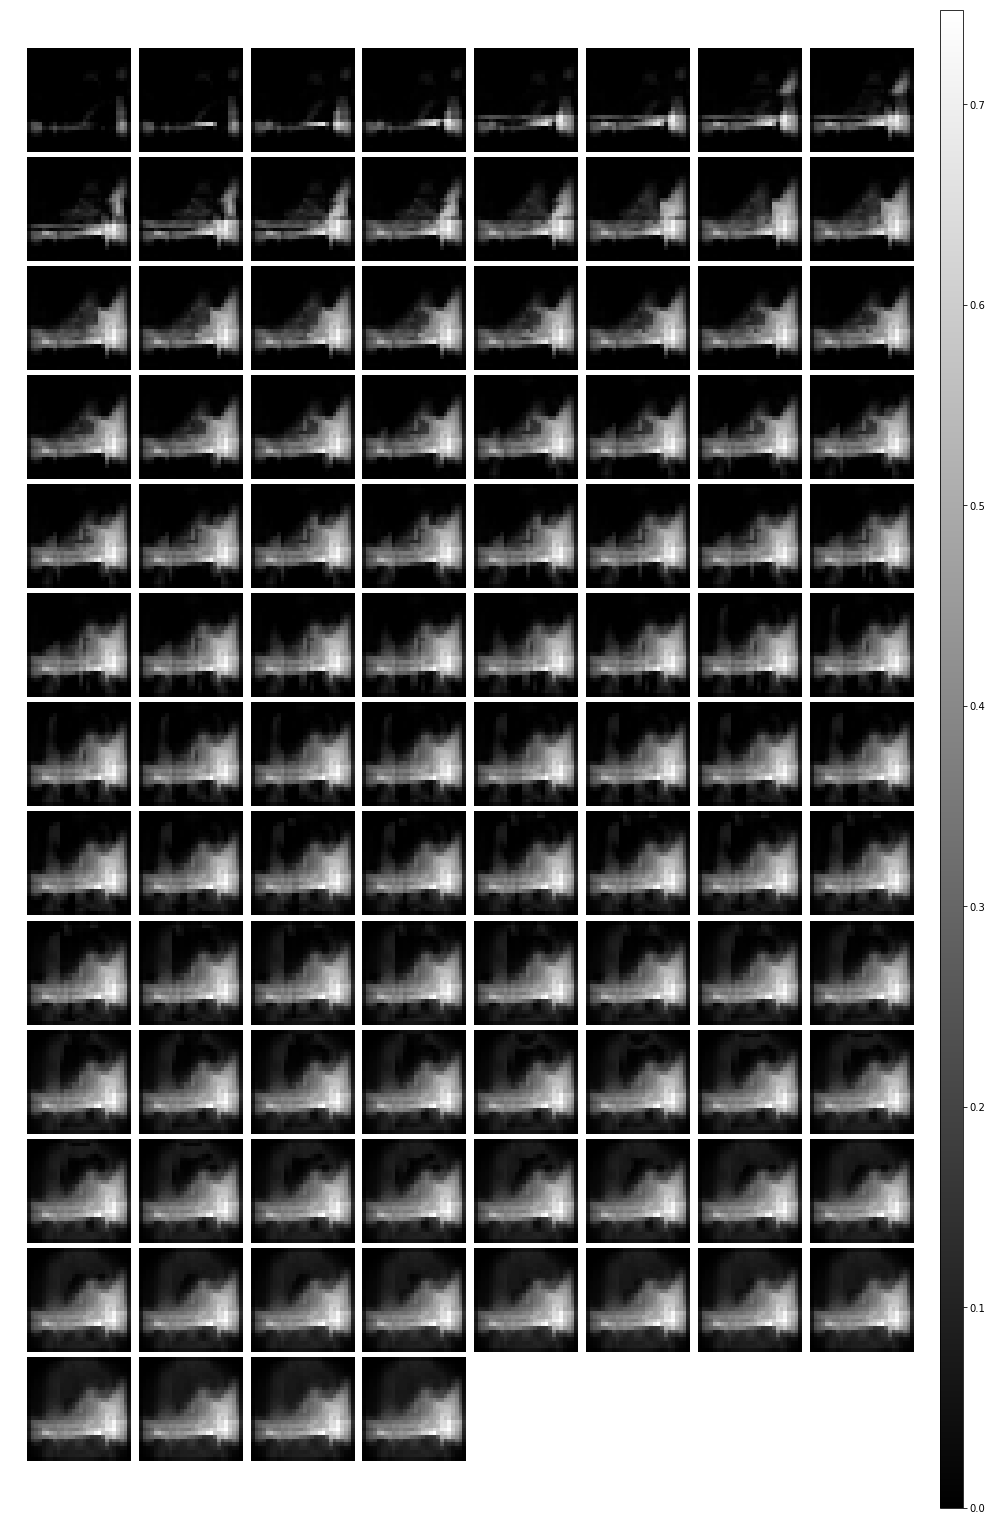

In [56]:
progressive_reconstruction(h_test[0], atoms, number_of_steps=100)

In [44]:
atoms_0 = atoms[idx_sort[-3:],:,:,:]

In [35]:
def plot_reconstruction_using_three_most_used_atoms_as_rgb(h_image, atoms):
    _, nb_rows, nb_columns, _ = atoms.shape
    idx_sort = np.flip(np.argsort(h_image))
    major_h = h_image[idx_sort[:3]]
    major_atoms = atoms[idx_sort[:3]].reshape((3, nb_rows*nb_columns))
    rgb_image = np.swapaxes(np.dot(np.diag(major_h), major_atoms), 0, 1).reshape((nb_rows,nb_columns,3))
    vmax=np.max(rgb_image)
    rgb_image = rgb_image/vmax
    plt.imshow(rgb_image)
    plt.show()

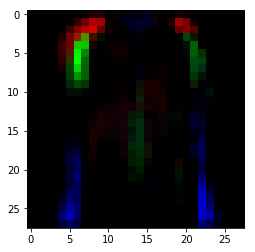

In [34]:
plot_reconstruction_using_three_most_used_atoms_as_rgb(h_test[1], atoms)

In [71]:
def jaccard_index(A,B):
    if (not np.any(A)) and (not np.any(B)):
        print("Warning: Two empty sets given in computation of jaccard index...returning 0...")
        return 0
    else:
        A_union_B = np.logical_or(A,B)
        A_inter_B = np.logical_and(A,B)
        jaccard_index = np.sum(A_inter_B)/np.sum(A_union_B)
        return jaccard_index

In [34]:
def mean_Jaccard_index(atoms, binarization_threshold=0.5):
    atoms_bin = atoms[:,:,:,0] > binarization_threshold
    nb_atoms,_,_ = atoms_bin.shape
    nb_pairs = nb_atoms*(nb_atoms-1)/2.
    s = 0
    for i in range(nb_atoms):
        for j in range(i+1,nb_atoms):
            s += jaccard_index(atoms_bin[i], atoms_bin[j])
    return s/nb_pairs

In [31]:
def overlap_coef(A,B):
    if (not np.any(A)) and (not np.any(B)):
        print("Warning: Two empty sets given in computation of overlap coef...returning 0...")
        return 0
    else:
        A_inter_B = np.logical_and(A,B)
        overlap_coef = np.sum(A_inter_B)/min(np.sum(A),np.sum(B))
        return overlap_coef


In [35]:
def mean_overlap_coef(atoms, binarization_threshold=0.5):
    atoms_bin = atoms[:,:,:,0] > binarization_threshold
    nb_atoms,_,_ = atoms_bin.shape
    nb_pairs = nb_atoms*(nb_atoms-1)/2.
    s = 0
    for i in range(nb_atoms):
        for j in range(i+1,nb_atoms):
            s += overlap_coef(atoms_bin[i], atoms_bin[j])
    return s/nb_pairs

In [36]:
mean_Jaccard_index(atoms)

0.0034698669788043642

In [37]:
mean_overlap_coef(atoms)

0.00876379540773481

In [49]:
def mean_number_overlapped_atoms_at_each_pixel(atoms, binarization_threshold=0.5):
    atoms_bin = atoms[:,:,:,0] > binarization_threshold
    nb_atoms, nb_rows, nb_columns, _ = atoms.shape
    s = 0
    for i in range(nb_rows):
        for j in range(nb_columns):
            s += np.sum(atoms_bin[:,i,j])
    return s /(nb_rows*nb_columns)

In [50]:
mean_number_overlapped_atoms_at_each_pixel(atoms)

1.1084183673469388

In [51]:
mean_number_overlapped_atoms_at_each_pixel(atoms_dil)

3.0892857142857144

In [42]:
mean_Jaccard_index(atoms_dil)

0.020182092428253372

In [43]:
mean_overlap_coef(atoms_dil)

0.04407765408612468

In [5]:
np.mean(atoms)

0.018506791

In [62]:
np.quantile(atoms, 0.99)

0.564537685513481

In [45]:
np.max(atoms)

2.5690124

In [52]:
mean_number_overlapped_atoms_at_each_pixel(atoms, binarization_threshold=2.569/2)

0.34311224489795916

In [36]:
mean_Jaccard_index(atoms, binarization_threshold=2.569/2)

0.0034698669788043642

In [37]:
mean_overlap_coef(atoms)

0.00876379540773481

In [ ]:
def mean_Jaccard_index(atoms, h_test_image, binarization_threshold=0.5):
    weighted_atoms = np.dot(np.diag(h_test_image), atoms)
    atoms_bin = atoms[:,:,:,0] > binarization_threshold
    nb_atoms,_,_ = atoms_bin.shape
    nb_pairs = nb_atoms*(nb_atoms-1)/2.
    s = 0
    for i in range(nb_atoms):
        for j in range(i+1,nb_atoms):
            s += jaccard_index(atoms_bin[i], atoms_bin[j])
    return s/nb_pairs

In [6]:
from skimage import filters

In [38]:
f = np.zeros(100)
for i in range(100):
    f[i] = filters.threshold_otsu(weighted_atoms[i])
    

In [43]:
np.max(f)

0.5679332482641646

In [61]:

mean_Otsu_binarization_threshold(weighted_atoms)

0.19356588359888133

In [7]:
from skimage import filters

def mean_Otsu_binarization_threshold(images):
    nb_images,_,_ = images.shape
    thresholds = np.zeros(nb_images)
    for i in range(nb_images):
        thresholds[i] = filters.threshold_otsu(images[i])
    return np.mean(thresholds)

def jaccard_index(A,B):
    if (not np.any(A)) and (not np.any(B)):
        #print("Warning: Two empty sets given in computation of jaccard index...returning 0...")
        return 0
    else:
        A_union_B = np.logical_or(A,B)
        A_inter_B = np.logical_and(A,B)
        jaccard_index = np.sum(A_inter_B)/np.sum(A_union_B)
        return jaccard_index

def pair_wise_mean_Jaccard_index_of_binary_images(binary_images):
    nb_images,_,_ = binary_images.shape
    nb_pairs = nb_images*(nb_images-1)/2.
    s = 0
    for i in range(nb_images):
        for j in range(i+1,nb_images):
            s += jaccard_index(binary_images[i], binary_images[j])
    return s/nb_pairs

def pair_wise_mean_Jaccard_index_of_weighted_atoms(atoms, h_test_image):
    nb_atoms,nb_rows,nb_columns,_ = atoms.shape
    weighted_atoms = np.dot(np.diag(h_test_image), atoms.reshape((nb_atoms,nb_rows*nb_columns))).reshape((nb_atoms,nb_rows,nb_columns))
    binarization_theshold = mean_Otsu_binarization_threshold(weighted_atoms)
    print('*****Otsu binarization  threshold : ', binarization_theshold,' ******')
    bin_weighted_atoms = weighted_atoms > binarization_theshold
    return pair_wise_mean_Jaccard_index_of_binary_images(bin_weighted_atoms)

def mean_jaccard_index_of_atoms_weighted_by_images_code(atoms, h_test):
    nb_samples, _ = h_test.shape
    s = 0
    for i in range(nb_samples):
        print('******Image: ', i, ' ******')
        tmp = pair_wise_mean_Jaccard_index_of_weighted_atoms(atoms, h_test[i])
        s += tmp
        print('***Mean Jaccard Index: ', tmp)
        print('\n')
    return s/nb_samples

In [84]:
h_test_0 = h_test[0]
weighted_atoms_0 = np.dot(np.diag(h_test_0), atoms.reshape((100,28*28))).reshape((100,28,28))

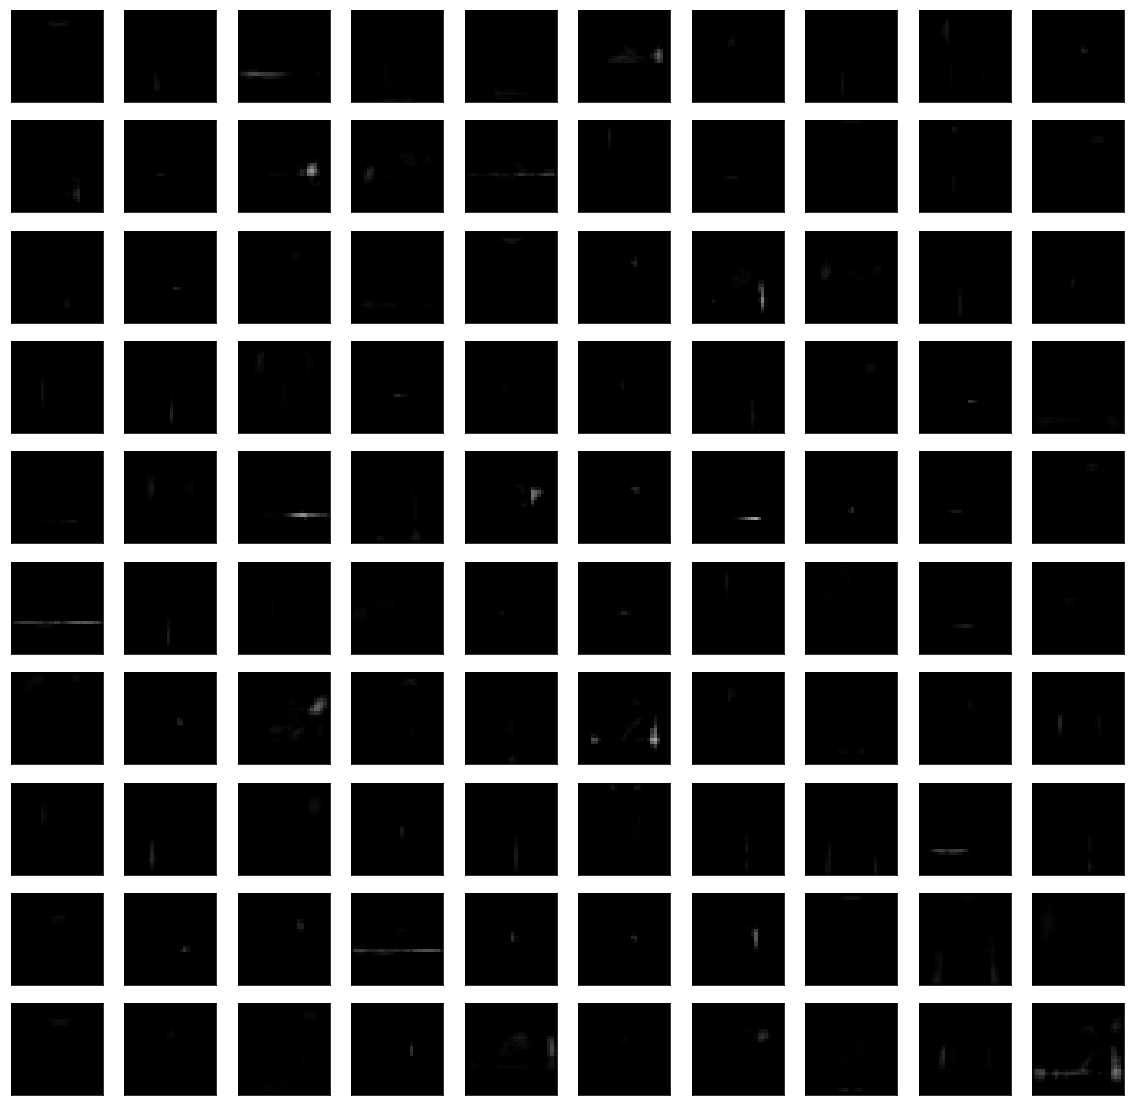

In [89]:
bastien_utils.plot_all_images(weighted_atoms_0.reshape((100,28,28,1)), relative_intensity=False)

In [86]:
thr = mean_Otsu_binarization_threshold(weighted_atoms_0)

In [90]:
bin_weighted_atoms_0 = weighted_atoms_0 > thr

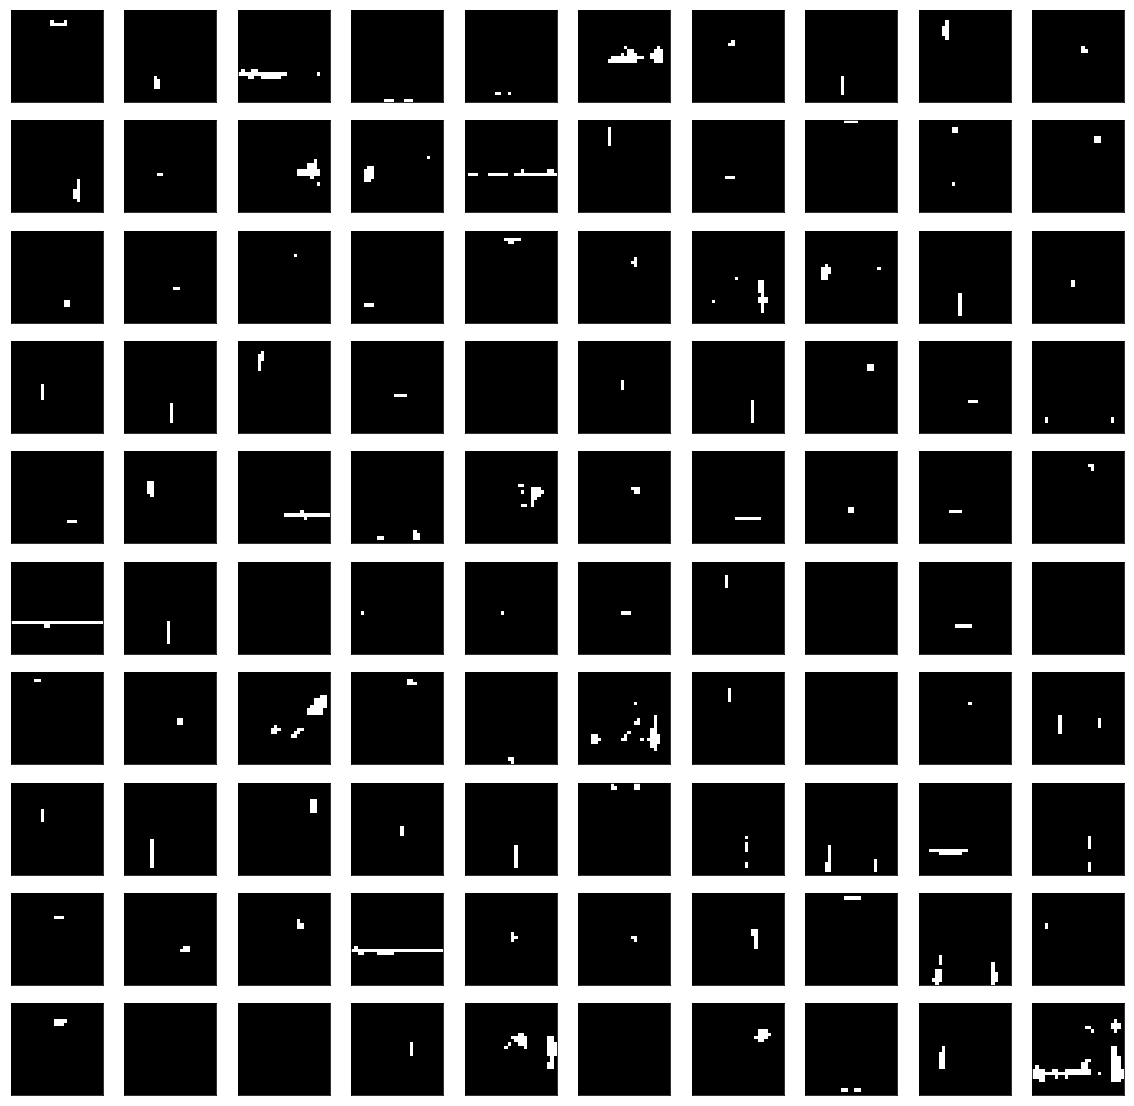

In [91]:
bastien_utils.plot_all_images(bin_weighted_atoms_0.reshape((100,28,28,1)))

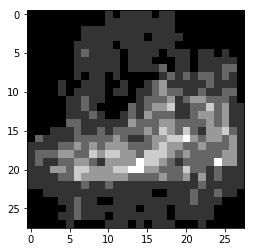

In [92]:
plt.imshow(np.sum(bin_weighted_atoms_0, axis=0))

In [81]:
mean_jaccard_index_of_atoms_weighted_by_images_code(atoms, h_test[:10])

******Image:  0  ******
*****Otsu binarization  threshold :  0.03567785164088797  ******
***Mean Jaccard Index:  0.002811855365156647


******Image:  1  ******
*****Otsu binarization  threshold :  0.19356588359888133  ******
***Mean Jaccard Index:  0.0038332169652714487


******Image:  2  ******
*****Otsu binarization  threshold :  0.10968260356650728  ******
***Mean Jaccard Index:  0.002508385634633889


******Image:  3  ******
*****Otsu binarization  threshold :  0.05689107765368044  ******
***Mean Jaccard Index:  0.001866129356540989


******Image:  4  ******
*****Otsu binarization  threshold :  0.06372098921716313  ******
***Mean Jaccard Index:  0.0037400163895229973


******Image:  5  ******
*****Otsu binarization  threshold :  0.08258788825331782  ******
***Mean Jaccard Index:  0.002530275274242489


******Image:  6  ******
*****Otsu binarization  threshold :  0.02803496011040417  ******
***Mean Jaccard Index:  0.0022249282347545076


******Image:  7  ******
*****Otsu binarizatio

0.0027915943430564783

In [8]:
mean_jaccard_index_of_atoms_weighted_by_images_code(atoms, h_test[:1000])

******Image:  0  ******
*****Otsu binarization  threshold :  0.03567785164088797  ******
***Mean Jaccard Index:  0.002811855365156647


******Image:  1  ******
*****Otsu binarization  threshold :  0.19356588359888133  ******
***Mean Jaccard Index:  0.0038332169652714487


******Image:  2  ******
*****Otsu binarization  threshold :  0.10968260356650728  ******
***Mean Jaccard Index:  0.002508385634633889


******Image:  3  ******
*****Otsu binarization  threshold :  0.05689107765368044  ******
***Mean Jaccard Index:  0.001866129356540989


******Image:  4  ******
*****Otsu binarization  threshold :  0.06372098921716313  ******
***Mean Jaccard Index:  0.0037400163895229973


******Image:  5  ******
*****Otsu binarization  threshold :  0.08258788825331782  ******
***Mean Jaccard Index:  0.002530275274242489


******Image:  6  ******
*****Otsu binarization  threshold :  0.02803496011040417  ******
***Mean Jaccard Index:  0.0022249282347545076


******Image:  7  ******
*****Otsu binarizatio

***Mean Jaccard Index:  0.002511492390896532


******Image:  61  ******
*****Otsu binarization  threshold :  0.05390980385740555  ******
***Mean Jaccard Index:  0.002845561231638999


******Image:  62  ******
*****Otsu binarization  threshold :  0.11289403347865998  ******
***Mean Jaccard Index:  0.0035997093775344286


******Image:  63  ******
*****Otsu binarization  threshold :  0.018934193516622143  ******
***Mean Jaccard Index:  0.0027652330930686723


******Image:  64  ******
*****Otsu binarization  threshold :  0.11895576971817759  ******
***Mean Jaccard Index:  0.0026483996842995516


******Image:  65  ******
*****Otsu binarization  threshold :  0.032082325791761755  ******
***Mean Jaccard Index:  0.00227160474187209


******Image:  66  ******
*****Otsu binarization  threshold :  0.029651736154568526  ******
***Mean Jaccard Index:  0.0030302740413687378


******Image:  67  ******
*****Otsu binarization  threshold :  0.12212999008027277  ******
***Mean Jaccard Index:  0.002639878

***Mean Jaccard Index:  0.003238047122565043


******Image:  121  ******
*****Otsu binarization  threshold :  0.17551647590778907  ******
***Mean Jaccard Index:  0.003575681419230951


******Image:  122  ******
*****Otsu binarization  threshold :  0.03282766786978038  ******
***Mean Jaccard Index:  0.0034218286137194798


******Image:  123  ******
*****Otsu binarization  threshold :  0.10091466167900386  ******
***Mean Jaccard Index:  0.0031823067361666153


******Image:  124  ******
*****Otsu binarization  threshold :  0.18022067863010954  ******
***Mean Jaccard Index:  0.003090557834330824


******Image:  125  ******
*****Otsu binarization  threshold :  0.13738396277146703  ******
***Mean Jaccard Index:  0.003645952634183499


******Image:  126  ******
*****Otsu binarization  threshold :  0.05703888852727767  ******
***Mean Jaccard Index:  0.0037231124230688423


******Image:  127  ******
*****Otsu binarization  threshold :  0.15319740591380998  ******
***Mean Jaccard Index:  0.00349

***Mean Jaccard Index:  0.0029981607124171692


******Image:  182  ******
*****Otsu binarization  threshold :  0.2035275603085811  ******
***Mean Jaccard Index:  0.0034823971085769104


******Image:  183  ******
*****Otsu binarization  threshold :  0.11477347710311557  ******
***Mean Jaccard Index:  0.0032540156720734497


******Image:  184  ******
*****Otsu binarization  threshold :  0.04787974659507882  ******
***Mean Jaccard Index:  0.002306675049340818


******Image:  185  ******
*****Otsu binarization  threshold :  0.08805585362056419  ******
***Mean Jaccard Index:  0.003456109152850699


******Image:  186  ******
*****Otsu binarization  threshold :  0.06220528406475172  ******
***Mean Jaccard Index:  0.002356518570126498


******Image:  187  ******
*****Otsu binarization  threshold :  0.18605544114933667  ******
***Mean Jaccard Index:  0.0038807287840535117


******Image:  188  ******
*****Otsu binarization  threshold :  0.22212123684037632  ******
***Mean Jaccard Index:  0.00388

***Mean Jaccard Index:  0.003844820659080324


******Image:  242  ******
*****Otsu binarization  threshold :  0.14265611291746985  ******
***Mean Jaccard Index:  0.0034037467441619014


******Image:  243  ******
*****Otsu binarization  threshold :  0.020908908424592757  ******
***Mean Jaccard Index:  0.0031969467379016274


******Image:  244  ******
*****Otsu binarization  threshold :  0.18672394144977533  ******
***Mean Jaccard Index:  0.0031371528385920277


******Image:  245  ******
*****Otsu binarization  threshold :  0.14661698643792287  ******
***Mean Jaccard Index:  0.0036157653845499847


******Image:  246  ******
*****Otsu binarization  threshold :  0.06102738213130784  ******
***Mean Jaccard Index:  0.00350073084934063


******Image:  247  ******
*****Otsu binarization  threshold :  0.1796650539766958  ******
***Mean Jaccard Index:  0.0035479171926722443


******Image:  248  ******
*****Otsu binarization  threshold :  0.0757703248726639  ******
***Mean Jaccard Index:  0.00374

***Mean Jaccard Index:  0.003088491765042894


******Image:  302  ******
*****Otsu binarization  threshold :  0.2143517210617455  ******
***Mean Jaccard Index:  0.003892722869780579


******Image:  303  ******
*****Otsu binarization  threshold :  0.16874528841380737  ******
***Mean Jaccard Index:  0.003950964946388265


******Image:  304  ******
*****Otsu binarization  threshold :  0.19295540091243804  ******
***Mean Jaccard Index:  0.003624037335304689


******Image:  305  ******
*****Otsu binarization  threshold :  0.1273979452864819  ******
***Mean Jaccard Index:  0.0032275322965386074


******Image:  306  ******
*****Otsu binarization  threshold :  0.1610394856866559  ******
***Mean Jaccard Index:  0.00332090456494699


******Image:  307  ******
*****Otsu binarization  threshold :  0.09001327559415107  ******
***Mean Jaccard Index:  0.0031320147240862383


******Image:  308  ******
*****Otsu binarization  threshold :  0.04378172475343896  ******
***Mean Jaccard Index:  0.0023764886

***Mean Jaccard Index:  0.003796982685387651


******Image:  362  ******
*****Otsu binarization  threshold :  0.15883429239113134  ******
***Mean Jaccard Index:  0.0034588339657364935


******Image:  363  ******
*****Otsu binarization  threshold :  0.0914625695364786  ******
***Mean Jaccard Index:  0.0032678649664069376


******Image:  364  ******
*****Otsu binarization  threshold :  0.17063165439722647  ******
***Mean Jaccard Index:  0.0037683392335002516


******Image:  365  ******
*****Otsu binarization  threshold :  0.03236868883463004  ******
***Mean Jaccard Index:  0.0024258886750891323


******Image:  366  ******
*****Otsu binarization  threshold :  0.15349666342050772  ******
***Mean Jaccard Index:  0.0030232002156470443


******Image:  367  ******
*****Otsu binarization  threshold :  0.2043972293998584  ******
***Mean Jaccard Index:  0.0042464555616352016


******Image:  368  ******
*****Otsu binarization  threshold :  0.1959981113630612  ******
***Mean Jaccard Index:  0.00389

***Mean Jaccard Index:  0.0033774925536096405


******Image:  422  ******
*****Otsu binarization  threshold :  0.1793908912084192  ******
***Mean Jaccard Index:  0.004157004235965717


******Image:  423  ******
*****Otsu binarization  threshold :  0.013700249729912805  ******
***Mean Jaccard Index:  0.0034209161990183014


******Image:  424  ******
*****Otsu binarization  threshold :  0.13726953512494244  ******
***Mean Jaccard Index:  0.00418205901110058


******Image:  425  ******
*****Otsu binarization  threshold :  0.05756823637106161  ******
***Mean Jaccard Index:  0.003318223175621487


******Image:  426  ******
*****Otsu binarization  threshold :  0.11121589957121451  ******
***Mean Jaccard Index:  0.0033414592295309365


******Image:  427  ******
*****Otsu binarization  threshold :  0.08052643488849659  ******
***Mean Jaccard Index:  0.003098775061993289


******Image:  428  ******
*****Otsu binarization  threshold :  0.07551625348431668  ******
***Mean Jaccard Index:  0.003381

***Mean Jaccard Index:  0.0026968337126991176


******Image:  482  ******
*****Otsu binarization  threshold :  0.14963765950647434  ******
***Mean Jaccard Index:  0.0029793050087283724


******Image:  483  ******
*****Otsu binarization  threshold :  0.028606172987082013  ******
***Mean Jaccard Index:  0.003001585888443864


******Image:  484  ******
*****Otsu binarization  threshold :  0.030098546581505844  ******
***Mean Jaccard Index:  0.002364392950257574


******Image:  485  ******
*****Otsu binarization  threshold :  0.05493594294543343  ******
***Mean Jaccard Index:  0.003288100095118291


******Image:  486  ******
*****Otsu binarization  threshold :  0.04893617215792934  ******
***Mean Jaccard Index:  0.0034302189996137634


******Image:  487  ******
*****Otsu binarization  threshold :  0.03757430194064546  ******
***Mean Jaccard Index:  0.0022110750862204473


******Image:  488  ******
*****Otsu binarization  threshold :  0.07583758303086609  ******
***Mean Jaccard Index:  0.00

***Mean Jaccard Index:  0.003346670295809729


******Image:  542  ******
*****Otsu binarization  threshold :  0.067007097120712  ******
***Mean Jaccard Index:  0.0028880113253635814


******Image:  543  ******
*****Otsu binarization  threshold :  0.10344849977316273  ******
***Mean Jaccard Index:  0.002876555488223


******Image:  544  ******
*****Otsu binarization  threshold :  0.03115339081621241  ******
***Mean Jaccard Index:  0.0018473856370027017


******Image:  545  ******
*****Otsu binarization  threshold :  0.10847771458375637  ******
***Mean Jaccard Index:  0.0025613517715036434


******Image:  546  ******
*****Otsu binarization  threshold :  0.11125496375825598  ******
***Mean Jaccard Index:  0.002982026574178335


******Image:  547  ******
*****Otsu binarization  threshold :  0.14436237602318222  ******
***Mean Jaccard Index:  0.0033690981501853763


******Image:  548  ******
*****Otsu binarization  threshold :  0.03082541998369392  ******
***Mean Jaccard Index:  0.003813812

***Mean Jaccard Index:  0.003529479030586586


******Image:  602  ******
*****Otsu binarization  threshold :  0.028906809701814393  ******
***Mean Jaccard Index:  0.0029902372834525104


******Image:  603  ******
*****Otsu binarization  threshold :  0.014146169887008363  ******
***Mean Jaccard Index:  0.00323163358124852


******Image:  604  ******
*****Otsu binarization  threshold :  0.09780345491191383  ******
***Mean Jaccard Index:  0.0026212907282329176


******Image:  605  ******
*****Otsu binarization  threshold :  0.026093123117630776  ******
***Mean Jaccard Index:  0.0033672010292698433


******Image:  606  ******
*****Otsu binarization  threshold :  0.06906243033718859  ******
***Mean Jaccard Index:  0.0035430259828020316


******Image:  607  ******
*****Otsu binarization  threshold :  0.014966431790518072  ******
***Mean Jaccard Index:  0.003624771819337998


******Image:  608  ******
*****Otsu binarization  threshold :  0.11590408693770643  ******
***Mean Jaccard Index:  0.0

***Mean Jaccard Index:  0.0029869019555214637


******Image:  662  ******
*****Otsu binarization  threshold :  0.10447279806732394  ******
***Mean Jaccard Index:  0.0025406420318970654


******Image:  663  ******
*****Otsu binarization  threshold :  0.03469147689491398  ******
***Mean Jaccard Index:  0.0020721904079514138


******Image:  664  ******
*****Otsu binarization  threshold :  0.01713757606328736  ******
***Mean Jaccard Index:  0.0032756842258414797


******Image:  665  ******
*****Otsu binarization  threshold :  0.22028710636063806  ******
***Mean Jaccard Index:  0.003960353232393541


******Image:  666  ******
*****Otsu binarization  threshold :  0.12554848868255009  ******
***Mean Jaccard Index:  0.0030959982033392916


******Image:  667  ******
*****Otsu binarization  threshold :  0.08936446052431064  ******
***Mean Jaccard Index:  0.003122099912024915


******Image:  668  ******
*****Otsu binarization  threshold :  0.04455980877840313  ******
***Mean Jaccard Index:  0.003

***Mean Jaccard Index:  0.0034842218307432164


******Image:  722  ******
*****Otsu binarization  threshold :  0.042089641148471316  ******
***Mean Jaccard Index:  0.0023152597615270104


******Image:  723  ******
*****Otsu binarization  threshold :  0.08337533004973502  ******
***Mean Jaccard Index:  0.0035688822068084334


******Image:  724  ******
*****Otsu binarization  threshold :  0.01825733659318984  ******
***Mean Jaccard Index:  0.0033345754165571423


******Image:  725  ******
*****Otsu binarization  threshold :  0.0969633378316618  ******
***Mean Jaccard Index:  0.0032932284641000002


******Image:  726  ******
*****Otsu binarization  threshold :  0.11878834960579548  ******
***Mean Jaccard Index:  0.0037293067676448096


******Image:  727  ******
*****Otsu binarization  threshold :  0.14137210582565254  ******
***Mean Jaccard Index:  0.003573455144238856


******Image:  728  ******
*****Otsu binarization  threshold :  0.07634383627661055  ******
***Mean Jaccard Index:  0.00

***Mean Jaccard Index:  0.003961849742078335


******Image:  782  ******
*****Otsu binarization  threshold :  0.058558989682886926  ******
***Mean Jaccard Index:  0.0024488815948692753


******Image:  783  ******
*****Otsu binarization  threshold :  0.06094651066325892  ******
***Mean Jaccard Index:  0.002883553598687357


******Image:  784  ******
*****Otsu binarization  threshold :  0.05761436280749755  ******
***Mean Jaccard Index:  0.002638086297127933


******Image:  785  ******
*****Otsu binarization  threshold :  0.03372350834672223  ******
***Mean Jaccard Index:  0.0026614199372293006


******Image:  786  ******
*****Otsu binarization  threshold :  0.14717498391241363  ******
***Mean Jaccard Index:  0.003186166776588021


******Image:  787  ******
*****Otsu binarization  threshold :  0.11634430123901059  ******
***Mean Jaccard Index:  0.00260958384683571


******Image:  788  ******
*****Otsu binarization  threshold :  0.08378657626893667  ******
***Mean Jaccard Index:  0.002777

***Mean Jaccard Index:  0.0030803347835430496


******Image:  842  ******
*****Otsu binarization  threshold :  0.04489287205910355  ******
***Mean Jaccard Index:  0.002955001477471044


******Image:  843  ******
*****Otsu binarization  threshold :  0.1251137768899579  ******
***Mean Jaccard Index:  0.002772193499694328


******Image:  844  ******
*****Otsu binarization  threshold :  0.08394257933707903  ******
***Mean Jaccard Index:  0.0021033091788447704


******Image:  845  ******
*****Otsu binarization  threshold :  0.061185404538048285  ******
***Mean Jaccard Index:  0.002616399388593202


******Image:  846  ******
*****Otsu binarization  threshold :  0.03477223081459692  ******
***Mean Jaccard Index:  0.003220758797961036


******Image:  847  ******
*****Otsu binarization  threshold :  0.03505688797535692  ******
***Mean Jaccard Index:  0.0030767698614268812


******Image:  848  ******
*****Otsu binarization  threshold :  0.08031921620641679  ******
***Mean Jaccard Index:  0.00337

***Mean Jaccard Index:  0.002625213487691045


******Image:  903  ******
*****Otsu binarization  threshold :  0.09973408286350084  ******
***Mean Jaccard Index:  0.0030073720702445206


******Image:  904  ******
*****Otsu binarization  threshold :  0.13661604908994407  ******
***Mean Jaccard Index:  0.003660387928723999


******Image:  905  ******
*****Otsu binarization  threshold :  0.09843868970803818  ******
***Mean Jaccard Index:  0.0035585017350515166


******Image:  906  ******
*****Otsu binarization  threshold :  0.02927858783595843  ******
***Mean Jaccard Index:  0.00311745718465547


******Image:  907  ******
*****Otsu binarization  threshold :  0.19182086578934596  ******
***Mean Jaccard Index:  0.003829686417491485


******Image:  908  ******
*****Otsu binarization  threshold :  0.16587133803513887  ******
***Mean Jaccard Index:  0.003478710829362126


******Image:  909  ******
*****Otsu binarization  threshold :  0.016765112337220563  ******
***Mean Jaccard Index:  0.002914

***Mean Jaccard Index:  0.0029365756687046345


******Image:  963  ******
*****Otsu binarization  threshold :  0.024822211107422984  ******
***Mean Jaccard Index:  0.0025615083211856355


******Image:  964  ******
*****Otsu binarization  threshold :  0.13315761162840783  ******
***Mean Jaccard Index:  0.0037552215425690526


******Image:  965  ******
*****Otsu binarization  threshold :  0.14238451584814502  ******
***Mean Jaccard Index:  0.003677309533594735


******Image:  966  ******
*****Otsu binarization  threshold :  0.16136418792909915  ******
***Mean Jaccard Index:  0.00310968331223504


******Image:  967  ******
*****Otsu binarization  threshold :  0.15978591092526184  ******
***Mean Jaccard Index:  0.003349391452486058


******Image:  968  ******
*****Otsu binarization  threshold :  0.049718135472756  ******
***Mean Jaccard Index:  0.0030904564936434886


******Image:  969  ******
*****Otsu binarization  threshold :  0.11138530119008246  ******
***Mean Jaccard Index:  0.003493

0.0031307328636939855

In [10]:
mean_jaccard_index_of_atoms_weighted_by_images_code(atoms_dil, h_test[:1000])

******Image:  0  ******
*****Otsu binarization  threshold :  0.04091954319880117  ******
***Mean Jaccard Index:  0.014239025957251633


******Image:  1  ******
*****Otsu binarization  threshold :  0.2215110328851631  ******
***Mean Jaccard Index:  0.016767936488581242


******Image:  2  ******
*****Otsu binarization  threshold :  0.1298353959225837  ******
***Mean Jaccard Index:  0.009009118107879016


******Image:  3  ******
*****Otsu binarization  threshold :  0.0657716570177628  ******
***Mean Jaccard Index:  0.007179699247531


******Image:  4  ******
*****Otsu binarization  threshold :  0.07359129664108927  ******
***Mean Jaccard Index:  0.017244946625535655


******Image:  5  ******
*****Otsu binarization  threshold :  0.09656584531347534  ******
***Mean Jaccard Index:  0.009786308870917153


******Image:  6  ******
*****Otsu binarization  threshold :  0.030756723714495088  ******
***Mean Jaccard Index:  0.009981069805897186


******Image:  7  ******
*****Otsu binarization  thres

***Mean Jaccard Index:  0.012809141307421806


******Image:  62  ******
*****Otsu binarization  threshold :  0.1301219077167167  ******
***Mean Jaccard Index:  0.015566230516137909


******Image:  63  ******
*****Otsu binarization  threshold :  0.022665398552885546  ******
***Mean Jaccard Index:  0.013163994888386769


******Image:  64  ******
*****Otsu binarization  threshold :  0.14013995606414872  ******
***Mean Jaccard Index:  0.009028574432997797


******Image:  65  ******
*****Otsu binarization  threshold :  0.03696316231634509  ******
***Mean Jaccard Index:  0.009379453013193628


******Image:  66  ******
*****Otsu binarization  threshold :  0.035246725433537185  ******
***Mean Jaccard Index:  0.01465469843225452


******Image:  67  ******
*****Otsu binarization  threshold :  0.1386423064457674  ******
***Mean Jaccard Index:  0.012835125676100366


******Image:  68  ******
*****Otsu binarization  threshold :  0.038403878479004776  ******
***Mean Jaccard Index:  0.014983649256806

***Mean Jaccard Index:  0.016046490285402792


******Image:  122  ******
*****Otsu binarization  threshold :  0.03761882074966437  ******
***Mean Jaccard Index:  0.016659349211264697


******Image:  123  ******
*****Otsu binarization  threshold :  0.11507071414194157  ******
***Mean Jaccard Index:  0.013524317358874776


******Image:  124  ******
*****Otsu binarization  threshold :  0.20766422805824064  ******
***Mean Jaccard Index:  0.01412283727078229


******Image:  125  ******
*****Otsu binarization  threshold :  0.15773948061812726  ******
***Mean Jaccard Index:  0.016555683435470415


******Image:  126  ******
*****Otsu binarization  threshold :  0.0649746956326559  ******
***Mean Jaccard Index:  0.017059663675324035


******Image:  127  ******
*****Otsu binarization  threshold :  0.1780020202988617  ******
***Mean Jaccard Index:  0.01698043782914222


******Image:  128  ******
*****Otsu binarization  threshold :  0.052031649919306054  ******
***Mean Jaccard Index:  0.00975347176

***Mean Jaccard Index:  0.013982905957795088


******Image:  182  ******
*****Otsu binarization  threshold :  0.23407525827952053  ******
***Mean Jaccard Index:  0.0165656663774424


******Image:  183  ******
*****Otsu binarization  threshold :  0.13166414832447648  ******
***Mean Jaccard Index:  0.016771236984549


******Image:  184  ******
*****Otsu binarization  threshold :  0.05560234664375062  ******
***Mean Jaccard Index:  0.008301876469372013


******Image:  185  ******
*****Otsu binarization  threshold :  0.10240695144338936  ******
***Mean Jaccard Index:  0.015573037986288382


******Image:  186  ******
*****Otsu binarization  threshold :  0.07226779810287717  ******
***Mean Jaccard Index:  0.010784340135626755


******Image:  187  ******
*****Otsu binarization  threshold :  0.21535257541082725  ******
***Mean Jaccard Index:  0.01832537558703794


******Image:  188  ******
*****Otsu binarization  threshold :  0.2551481348865682  ******
***Mean Jaccard Index:  0.018026123694877

***Mean Jaccard Index:  0.01742177620395737


******Image:  242  ******
*****Otsu binarization  threshold :  0.16691187372813418  ******
***Mean Jaccard Index:  0.013822728200629568


******Image:  243  ******
*****Otsu binarization  threshold :  0.023684969740754194  ******
***Mean Jaccard Index:  0.013721460724893018


******Image:  244  ******
*****Otsu binarization  threshold :  0.21659127552758334  ******
***Mean Jaccard Index:  0.014107143948008802


******Image:  245  ******
*****Otsu binarization  threshold :  0.17069262019833722  ******
***Mean Jaccard Index:  0.015500419159975392


******Image:  246  ******
*****Otsu binarization  threshold :  0.07034109231070115  ******
***Mean Jaccard Index:  0.015558309919570532


******Image:  247  ******
*****Otsu binarization  threshold :  0.21013498177786535  ******
***Mean Jaccard Index:  0.017058431199491204


******Image:  248  ******
*****Otsu binarization  threshold :  0.08671786930797072  ******
***Mean Jaccard Index:  0.01644657

***Mean Jaccard Index:  0.014256784689278764


******Image:  302  ******
*****Otsu binarization  threshold :  0.24791650752200478  ******
***Mean Jaccard Index:  0.01836338407333214


******Image:  303  ******
*****Otsu binarization  threshold :  0.19852516148781024  ******
***Mean Jaccard Index:  0.016295540833298188


******Image:  304  ******
*****Otsu binarization  threshold :  0.22151784411639966  ******
***Mean Jaccard Index:  0.01656203484502274


******Image:  305  ******
*****Otsu binarization  threshold :  0.14671173590827338  ******
***Mean Jaccard Index:  0.01579345532333348


******Image:  306  ******
*****Otsu binarization  threshold :  0.18725358671082  ******
***Mean Jaccard Index:  0.014915864492560653


******Image:  307  ******
*****Otsu binarization  threshold :  0.10519527773285862  ******
***Mean Jaccard Index:  0.013151821259702098


******Image:  308  ******
*****Otsu binarization  threshold :  0.05246355162438761  ******
***Mean Jaccard Index:  0.00851362723084

***Mean Jaccard Index:  0.0176868087661846


******Image:  362  ******
*****Otsu binarization  threshold :  0.1845594883530554  ******
***Mean Jaccard Index:  0.016227439205192755


******Image:  363  ******
*****Otsu binarization  threshold :  0.10481757154487908  ******
***Mean Jaccard Index:  0.015330424739973397


******Image:  364  ******
*****Otsu binarization  threshold :  0.1963828033756295  ******
***Mean Jaccard Index:  0.018383890224243936


******Image:  365  ******
*****Otsu binarization  threshold :  0.03749278339389554  ******
***Mean Jaccard Index:  0.012395562542177893


******Image:  366  ******
*****Otsu binarization  threshold :  0.17710334066758243  ******
***Mean Jaccard Index:  0.013138946294540809


******Image:  367  ******
*****Otsu binarization  threshold :  0.23408684781402633  ******
***Mean Jaccard Index:  0.01815090021703517


******Image:  368  ******
*****Otsu binarization  threshold :  0.2252863366341342  ******
***Mean Jaccard Index:  0.01809272157220

***Mean Jaccard Index:  0.016284844760750095


******Image:  422  ******
*****Otsu binarization  threshold :  0.206381570662476  ******
***Mean Jaccard Index:  0.01951798721491119


******Image:  423  ******
*****Otsu binarization  threshold :  0.01651091410709833  ******
***Mean Jaccard Index:  0.013513349090228085


******Image:  424  ******
*****Otsu binarization  threshold :  0.15692257870549756  ******
***Mean Jaccard Index:  0.017831709542268794


******Image:  425  ******
*****Otsu binarization  threshold :  0.06586805415167513  ******
***Mean Jaccard Index:  0.016165253908477745


******Image:  426  ******
*****Otsu binarization  threshold :  0.12806576802098274  ******
***Mean Jaccard Index:  0.015624745656779427


******Image:  427  ******
*****Otsu binarization  threshold :  0.09237056115093868  ******
***Mean Jaccard Index:  0.013719187392579385


******Image:  428  ******
*****Otsu binarization  threshold :  0.086768400577468  ******
***Mean Jaccard Index:  0.0141559078180

***Mean Jaccard Index:  0.011976699936451299


******Image:  482  ******
*****Otsu binarization  threshold :  0.17337381976726143  ******
***Mean Jaccard Index:  0.013619998024198774


******Image:  483  ******
*****Otsu binarization  threshold :  0.033912886816933455  ******
***Mean Jaccard Index:  0.0145769608649338


******Image:  484  ******
*****Otsu binarization  threshold :  0.036464802903134495  ******
***Mean Jaccard Index:  0.0097581956019995


******Image:  485  ******
*****Otsu binarization  threshold :  0.0627803214965119  ******
***Mean Jaccard Index:  0.015243080035137588


******Image:  486  ******
*****Otsu binarization  threshold :  0.05733450431285532  ******
***Mean Jaccard Index:  0.015920887037415926


******Image:  487  ******
*****Otsu binarization  threshold :  0.04386185132746579  ******
***Mean Jaccard Index:  0.010034803037780584


******Image:  488  ******
*****Otsu binarization  threshold :  0.08713674808849055  ******
***Mean Jaccard Index:  0.01579890448

***Mean Jaccard Index:  0.016718081283189922


******Image:  542  ******
*****Otsu binarization  threshold :  0.0776648676516505  ******
***Mean Jaccard Index:  0.01312844285887384


******Image:  543  ******
*****Otsu binarization  threshold :  0.11938895218476082  ******
***Mean Jaccard Index:  0.010244091287633605


******Image:  544  ******
*****Otsu binarization  threshold :  0.036858103497284155  ******
***Mean Jaccard Index:  0.00950286698167588


******Image:  545  ******
*****Otsu binarization  threshold :  0.12496608818484992  ******
***Mean Jaccard Index:  0.010076066009916647


******Image:  546  ******
*****Otsu binarization  threshold :  0.1274843839701291  ******
***Mean Jaccard Index:  0.01612361206037315


******Image:  547  ******
*****Otsu binarization  threshold :  0.16523135559014726  ******
***Mean Jaccard Index:  0.016039494979720282


******Image:  548  ******
*****Otsu binarization  threshold :  0.03522016403170889  ******
***Mean Jaccard Index:  0.016474148682

***Mean Jaccard Index:  0.015044754347254587


******Image:  603  ******
*****Otsu binarization  threshold :  0.01636577853364087  ******
***Mean Jaccard Index:  0.015651826222631688


******Image:  604  ******
*****Otsu binarization  threshold :  0.11332971495398832  ******
***Mean Jaccard Index:  0.01068608166388499


******Image:  605  ******
*****Otsu binarization  threshold :  0.029842465578720615  ******
***Mean Jaccard Index:  0.015790444567153925


******Image:  606  ******
*****Otsu binarization  threshold :  0.07999500850190219  ******
***Mean Jaccard Index:  0.014361143586922524


******Image:  607  ******
*****Otsu binarization  threshold :  0.017163750090546995  ******
***Mean Jaccard Index:  0.015212255941437488


******Image:  608  ******
*****Otsu binarization  threshold :  0.13433654746048962  ******
***Mean Jaccard Index:  0.015955706780576454


******Image:  609  ******
*****Otsu binarization  threshold :  0.08114838603211076  ******
***Mean Jaccard Index:  0.0127457

***Mean Jaccard Index:  0.01048528132643237


******Image:  663  ******
*****Otsu binarization  threshold :  0.0405191558631031  ******
***Mean Jaccard Index:  0.009742989075319898


******Image:  664  ******
*****Otsu binarization  threshold :  0.019718482542126218  ******
***Mean Jaccard Index:  0.014595641238835017


******Image:  665  ******
*****Otsu binarization  threshold :  0.2537792874241135  ******
***Mean Jaccard Index:  0.018787055611643975


******Image:  666  ******
*****Otsu binarization  threshold :  0.14419960749155514  ******
***Mean Jaccard Index:  0.012455588832108195


******Image:  667  ******
*****Otsu binarization  threshold :  0.10521110855242571  ******
***Mean Jaccard Index:  0.012798632123942656


******Image:  668  ******
*****Otsu binarization  threshold :  0.05123605583038184  ******
***Mean Jaccard Index:  0.01584045951184301


******Image:  669  ******
*****Otsu binarization  threshold :  0.035226283391730666  ******
***Mean Jaccard Index:  0.0129047352

***Mean Jaccard Index:  0.0176856429971376


******Image:  724  ******
*****Otsu binarization  threshold :  0.021308803428332253  ******
***Mean Jaccard Index:  0.013594399055797264


******Image:  725  ******
*****Otsu binarization  threshold :  0.11313252030153186  ******
***Mean Jaccard Index:  0.014299175177832371


******Image:  726  ******
*****Otsu binarization  threshold :  0.13573893316947058  ******
***Mean Jaccard Index:  0.01773277576124089


******Image:  727  ******
*****Otsu binarization  threshold :  0.16347408632058047  ******
***Mean Jaccard Index:  0.017271128564174502


******Image:  728  ******
*****Otsu binarization  threshold :  0.08815896076544272  ******
***Mean Jaccard Index:  0.009968955487804633


******Image:  729  ******
*****Otsu binarization  threshold :  0.019416712396537583  ******
***Mean Jaccard Index:  0.011973093273202824


******Image:  730  ******
*****Otsu binarization  threshold :  0.08279567297161596  ******
***Mean Jaccard Index:  0.013537938

***Mean Jaccard Index:  0.01062684987390027


******Image:  784  ******
*****Otsu binarization  threshold :  0.06655015252440034  ******
***Mean Jaccard Index:  0.011436182927774756


******Image:  785  ******
*****Otsu binarization  threshold :  0.03799078331857684  ******
***Mean Jaccard Index:  0.01267966067523418


******Image:  786  ******
*****Otsu binarization  threshold :  0.16940594485958055  ******
***Mean Jaccard Index:  0.012505986048499347


******Image:  787  ******
*****Otsu binarization  threshold :  0.12965460707162485  ******
***Mean Jaccard Index:  0.010683100480054709


******Image:  788  ******
*****Otsu binarization  threshold :  0.09681006670984321  ******
***Mean Jaccard Index:  0.011977891612433192


******Image:  789  ******
*****Otsu binarization  threshold :  0.04300817362930951  ******
***Mean Jaccard Index:  0.008621986842163967


******Image:  790  ******
*****Otsu binarization  threshold :  0.09376883958559247  ******
***Mean Jaccard Index:  0.0097816417

***Mean Jaccard Index:  0.01108710183085879


******Image:  844  ******
*****Otsu binarization  threshold :  0.0943745698459657  ******
***Mean Jaccard Index:  0.008684252450108834


******Image:  845  ******
*****Otsu binarization  threshold :  0.07032819550400211  ******
***Mean Jaccard Index:  0.00902835825785881


******Image:  846  ******
*****Otsu binarization  threshold :  0.0402312727131316  ******
***Mean Jaccard Index:  0.013063741131875427


******Image:  847  ******
*****Otsu binarization  threshold :  0.04090246613424619  ******
***Mean Jaccard Index:  0.013685995723600334


******Image:  848  ******
*****Otsu binarization  threshold :  0.09333897761069845  ******
***Mean Jaccard Index:  0.014823479056056835


******Image:  849  ******
*****Otsu binarization  threshold :  0.0913638977821977  ******
***Mean Jaccard Index:  0.012472928638722642


******Image:  850  ******
*****Otsu binarization  threshold :  0.12414115744198619  ******
***Mean Jaccard Index:  0.0142210464744

***Mean Jaccard Index:  0.01421492174881986


******Image:  904  ******
*****Otsu binarization  threshold :  0.1584561939754188  ******
***Mean Jaccard Index:  0.017096507753303826


******Image:  905  ******
*****Otsu binarization  threshold :  0.11359430562204889  ******
***Mean Jaccard Index:  0.01676541791361057


******Image:  906  ******
*****Otsu binarization  threshold :  0.033798425493614295  ******
***Mean Jaccard Index:  0.014016758609106355


******Image:  907  ******
*****Otsu binarization  threshold :  0.2219097772577651  ******
***Mean Jaccard Index:  0.018506557756243925


******Image:  908  ******
*****Otsu binarization  threshold :  0.19074757368649942  ******
***Mean Jaccard Index:  0.01562779462725195


******Image:  909  ******
*****Otsu binarization  threshold :  0.019537918847745236  ******
***Mean Jaccard Index:  0.012164381495045012


******Image:  910  ******
*****Otsu binarization  threshold :  0.13116236658717007  ******
***Mean Jaccard Index:  0.01384921584

***Mean Jaccard Index:  0.011716611179022474


******Image:  964  ******
*****Otsu binarization  threshold :  0.1518299306710438  ******
***Mean Jaccard Index:  0.017795365212102638


******Image:  965  ******
*****Otsu binarization  threshold :  0.16431631747973982  ******
***Mean Jaccard Index:  0.018211594942344464


******Image:  966  ******
*****Otsu binarization  threshold :  0.18689061571031196  ******
***Mean Jaccard Index:  0.013959831134475352


******Image:  967  ******
*****Otsu binarization  threshold :  0.18361241840792922  ******
***Mean Jaccard Index:  0.01591156438599369


******Image:  968  ******
*****Otsu binarization  threshold :  0.05687627408223702  ******
***Mean Jaccard Index:  0.014619121069462185


******Image:  969  ******
*****Otsu binarization  threshold :  0.13005108653885702  ******
***Mean Jaccard Index:  0.016431887052257628


******Image:  970  ******
*****Otsu binarization  threshold :  0.05888143181429368  ******
***Mean Jaccard Index:  0.0139672201

0.014036503920867518

In [21]:
np.mean(weighted_atoms)

0.008263176487744444

In [33]:
np.quantile(weighted_atoms, 0.90)

0.0019835191636670725

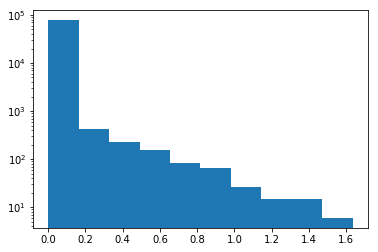

In [24]:
plt.hist(weighted_atoms.flatten())
plt.yscale('log')
plt.show()

In [27]:
from skimage import filters

def mean_Otsu_binarization_threshold_using_majors_images(images, h_test_image, nb_images_to_use=10):
    nb_images,_,_ = images.shape
    thresholds = np.zeros(nb_images_to_use)
    idx_sort = np.flip(np.argsort(h_test_image))
    for i in range(nb_images_to_use):
        thresholds[i] = filters.threshold_otsu(images[idx_sort[i]])
    return np.mean(thresholds)

def overlap_coef(A,B):
    if (not np.any(A)) or (not np.any(B)):
        #print("Warning: Two empty sets given in computation of jaccard index...returning 0...")
        return 0
    else:
        A_union_B = np.logical_or(A,B)
        A_inter_B = np.logical_and(A,B)
        overlap_coef = np.sum(A_inter_B)/min(np.sum(A), np.sum(B))
        return overlap_coef

def pair_wise_mean_overlap_coef_of_binary_images(binary_images):
    nb_images,_,_ = binary_images.shape
    nb_pairs = nb_images*(nb_images-1)/2.
    s = 0
    for i in range(nb_images):
        for j in range(i+1,nb_images):
            s += overlap_coef(binary_images[i], binary_images[j])
    return s/nb_pairs

def pair_wise_mean_overlap_coef_of_weighted_atoms(atoms, h_test_image, nb_images_to_use_for_threshold_computation=10):
    nb_atoms,nb_rows,nb_columns,_ = atoms.shape
    weighted_atoms = np.dot(np.diag(h_test_image), atoms.reshape((nb_atoms,nb_rows*nb_columns))).reshape((nb_atoms,nb_rows,nb_columns))
    binarization_theshold = mean_Otsu_binarization_threshold_using_majors_images(weighted_atoms, h_test_image, nb_images_to_use=nb_images_to_use_for_threshold_computation)
    print('*****Otsu binarization  threshold : ', binarization_theshold,' ******')
    bin_weighted_atoms = weighted_atoms > binarization_theshold
    return pair_wise_mean_overlap_coef_of_binary_images(bin_weighted_atoms)

def mean_overlap_coef_of_atoms_weighted_by_images_code(atoms, h_test, nb_images_to_use_for_threshold_computation=10):
    nb_samples, _ = h_test.shape
    s = 0
    for i in range(nb_samples):
        print('******Image: ', i, ' ******')
        tmp = pair_wise_mean_overlap_coef_of_weighted_atoms(atoms, h_test[i], nb_images_to_use_for_threshold_computation=nb_images_to_use_for_threshold_computation)
        s += tmp
        print('***Mean overlap coef: ', tmp)
        print('\n')
    return s/nb_samples

In [28]:
mean_overlap_coef_of_atoms_weighted_by_images_code(atoms, h_test[:1000])

******Image:  0  ******
*****Otsu binarization  threshold :  0.1265587250675737  ******
***Mean overlap coef:  0.0013541852672287454


******Image:  1  ******
*****Otsu binarization  threshold :  0.35603569329264706  ******
***Mean overlap coef:  0.0030088469330893566


******Image:  2  ******
*****Otsu binarization  threshold :  0.3016025358934745  ******
***Mean overlap coef:  0.0012573352573352578


******Image:  3  ******
*****Otsu binarization  threshold :  0.22050937423393174  ******
***Mean overlap coef:  0.0006722929147171571


******Image:  4  ******
*****Otsu binarization  threshold :  0.11781951377546196  ******
***Mean overlap coef:  0.0032071880387388395


******Image:  5  ******
*****Otsu binarization  threshold :  0.2282530687071163  ******
***Mean overlap coef:  0.0014295334295334299


******Image:  6  ******
*****Otsu binarization  threshold :  0.1437674246908595  ******
***Mean overlap coef:  0.00010774410774410775


******Image:  7  ******
*****Otsu binarization  thr

***Mean overlap coef:  0.0014887931603617878


******Image:  61  ******
*****Otsu binarization  threshold :  0.17862421696023892  ******
***Mean overlap coef:  0.0020232121737218463


******Image:  62  ******
*****Otsu binarization  threshold :  0.23920988009160168  ******
***Mean overlap coef:  0.004480063548889294


******Image:  63  ******
*****Otsu binarization  threshold :  0.05810887931380948  ******
***Mean overlap coef:  0.001715003851367488


******Image:  64  ******
*****Otsu binarization  threshold :  0.31779314019408955  ******
***Mean overlap coef:  0.0013491261824595162


******Image:  65  ******
*****Otsu binarization  threshold :  0.12121398042177214  ******
***Mean overlap coef:  0.00039105339105339104


******Image:  66  ******
*****Otsu binarization  threshold :  0.06415247908689861  ******
***Mean overlap coef:  0.0017855685279927708


******Image:  67  ******
*****Otsu binarization  threshold :  0.2958426745167218  ******
***Mean overlap coef:  0.001566859066859067

***Mean overlap coef:  0.0021419753086419748


******Image:  121  ******
*****Otsu binarization  threshold :  0.3161250482029083  ******
***Mean overlap coef:  0.003381688457446033


******Image:  122  ******
*****Otsu binarization  threshold :  0.08197054469488531  ******
***Mean overlap coef:  0.0019996218873224213


******Image:  123  ******
*****Otsu binarization  threshold :  0.2424302746498001  ******
***Mean overlap coef:  0.003943357840416662


******Image:  124  ******
*****Otsu binarization  threshold :  0.3590588497177326  ******
***Mean overlap coef:  0.00284216625125716


******Image:  125  ******
*****Otsu binarization  threshold :  0.23351900040051335  ******
***Mean overlap coef:  0.004171549319499407


******Image:  126  ******
*****Otsu binarization  threshold :  0.12097184639110295  ******
***Mean overlap coef:  0.0024452346623469613


******Image:  127  ******
*****Otsu binarization  threshold :  0.29890000729272403  ******
***Mean overlap coef:  0.00245601424389303

***Mean overlap coef:  0.004093593770064359


******Image:  181  ******
*****Otsu binarization  threshold :  0.19092391963186764  ******
***Mean overlap coef:  0.0033847072141783958


******Image:  182  ******
*****Otsu binarization  threshold :  0.3174562444576827  ******
***Mean overlap coef:  0.003813736207675601


******Image:  183  ******
*****Otsu binarization  threshold :  0.22540566997574416  ******
***Mean overlap coef:  0.0021762939641727513


******Image:  184  ******
*****Otsu binarization  threshold :  0.19126206361182904  ******
***Mean overlap coef:  0.0010683659444800267


******Image:  185  ******
*****Otsu binarization  threshold :  0.2019339676673675  ******
***Mean overlap coef:  0.003058887945368852


******Image:  186  ******
*****Otsu binarization  threshold :  0.1906190431018769  ******
***Mean overlap coef:  0.0013240719965318896


******Image:  187  ******
*****Otsu binarization  threshold :  0.3307076807332551  ******
***Mean overlap coef:  0.0034431516855759

***Mean overlap coef:  0.004109228419582599


******Image:  242  ******
*****Otsu binarization  threshold :  0.2804949285805515  ******
***Mean overlap coef:  0.0033752032854200004


******Image:  243  ******
*****Otsu binarization  threshold :  0.0787564151678933  ******
***Mean overlap coef:  0.00025645342312008977


******Image:  244  ******
*****Otsu binarization  threshold :  0.37704045460845637  ******
***Mean overlap coef:  0.0015553296310872073


******Image:  245  ******
*****Otsu binarization  threshold :  0.29178970513175606  ******
***Mean overlap coef:  0.0034143194814911957


******Image:  246  ******
*****Otsu binarization  threshold :  0.15353200080218715  ******
***Mean overlap coef:  0.0008805313653798503


******Image:  247  ******
*****Otsu binarization  threshold :  0.27927230027534466  ******
***Mean overlap coef:  0.004197768561404923


******Image:  248  ******
*****Otsu binarization  threshold :  0.14246189510830115  ******
***Mean overlap coef:  0.003617072470

***Mean overlap coef:  0.002154095063185972


******Image:  302  ******
*****Otsu binarization  threshold :  0.2953058149298885  ******
***Mean overlap coef:  0.0054454950212525915


******Image:  303  ******
*****Otsu binarization  threshold :  0.2716586539498557  ******
***Mean overlap coef:  0.005938036463553238


******Image:  304  ******
*****Otsu binarization  threshold :  0.29297253634424386  ******
***Mean overlap coef:  0.004193808436232676


******Image:  305  ******
*****Otsu binarization  threshold :  0.23399086129667776  ******
***Mean overlap coef:  0.003112277172883234


******Image:  306  ******
*****Otsu binarization  threshold :  0.2772888581976298  ******
***Mean overlap coef:  0.003184565862396802


******Image:  307  ******
*****Otsu binarization  threshold :  0.2203881479294318  ******
***Mean overlap coef:  0.003075469151249975


******Image:  308  ******
*****Otsu binarization  threshold :  0.17842022876115415  ******
***Mean overlap coef:  0.0011104461986814929

***Mean overlap coef:  0.0030251869342778426


******Image:  363  ******
*****Otsu binarization  threshold :  0.21428819585673448  ******
***Mean overlap coef:  0.0013079845486262598


******Image:  364  ******
*****Otsu binarization  threshold :  0.3074130920683494  ******
***Mean overlap coef:  0.0034967585725161465


******Image:  365  ******
*****Otsu binarization  threshold :  0.09794207635214738  ******
***Mean overlap coef:  0.001590624863352136


******Image:  366  ******
*****Otsu binarization  threshold :  0.3468446981189493  ******
***Mean overlap coef:  0.0025288746046321802


******Image:  367  ******
*****Otsu binarization  threshold :  0.3526807984072852  ******
***Mean overlap coef:  0.004858211373362887


******Image:  368  ******
*****Otsu binarization  threshold :  0.28158874151045116  ******
***Mean overlap coef:  0.006250931597693057


******Image:  369  ******
*****Otsu binarization  threshold :  0.12638618637015478  ******
***Mean overlap coef:  0.000702950185922

***Mean overlap coef:  0.002398044077395733


******Image:  424  ******
*****Otsu binarization  threshold :  0.2690372341436175  ******
***Mean overlap coef:  0.005480974973399215


******Image:  425  ******
*****Otsu binarization  threshold :  0.1689576203923777  ******
***Mean overlap coef:  0.000862914862914863


******Image:  426  ******
*****Otsu binarization  threshold :  0.2705127022053543  ******
***Mean overlap coef:  0.001415919658343901


******Image:  427  ******
*****Otsu binarization  threshold :  0.192063981610509  ******
***Mean overlap coef:  0.0033164071025033595


******Image:  428  ******
*****Otsu binarization  threshold :  0.2057090356624772  ******
***Mean overlap coef:  0.0029630478195157225


******Image:  429  ******
*****Otsu binarization  threshold :  0.165679942542617  ******
***Mean overlap coef:  0.0038722011302225186


******Image:  430  ******
*****Otsu binarization  threshold :  0.04869810842057431  ******
***Mean overlap coef:  0.00039587797163554735


*****Otsu binarization  threshold :  0.13697332149013428  ******
***Mean overlap coef:  0.0018302135574862848


******Image:  486  ******
*****Otsu binarization  threshold :  0.11478753187963817  ******
***Mean overlap coef:  0.0032215906571707122


******Image:  487  ******
*****Otsu binarization  threshold :  0.12161117675518465  ******
***Mean overlap coef:  0.000888728555395222


******Image:  488  ******
*****Otsu binarization  threshold :  0.16747835869129196  ******
***Mean overlap coef:  0.0025816162776947085


******Image:  489  ******
*****Otsu binarization  threshold :  0.2925144375871426  ******
***Mean overlap coef:  0.00315267593698966


******Image:  490  ******
*****Otsu binarization  threshold :  0.21809112367426348  ******
***Mean overlap coef:  0.0037330178239269127


******Image:  491  ******
*****Otsu binarization  threshold :  0.21754137784086072  ******
***Mean overlap coef:  0.0005753713177955604


******Image:  492  ******
*****Otsu binarization  threshold :  0

***Mean overlap coef:  0.0008278018278018277


******Image:  546  ******
*****Otsu binarization  threshold :  0.2522033293128755  ******
***Mean overlap coef:  0.0019896730654306413


******Image:  547  ******
*****Otsu binarization  threshold :  0.25204851694087954  ******
***Mean overlap coef:  0.0029211859969435717


******Image:  548  ******
*****Otsu binarization  threshold :  0.06640814203275522  ******
***Mean overlap coef:  0.0026891990979303728


******Image:  549  ******
*****Otsu binarization  threshold :  0.23633405988480854  ******
***Mean overlap coef:  0.002529395678940664


******Image:  550  ******
*****Otsu binarization  threshold :  0.05194939603368286  ******
***Mean overlap coef:  0.0011249289431107612


******Image:  551  ******
*****Otsu binarization  threshold :  0.2577871100909558  ******
***Mean overlap coef:  0.0006653985744894835


******Image:  552  ******
*****Otsu binarization  threshold :  0.12017537492326913  ******
***Mean overlap coef:  0.001881848790

***Mean overlap coef:  0.0004797178130511464


******Image:  608  ******
*****Otsu binarization  threshold :  0.26029861318281455  ******
***Mean overlap coef:  0.0015852604185937521


******Image:  609  ******
*****Otsu binarization  threshold :  0.22024342279305292  ******
***Mean overlap coef:  0.0021171030813336216


******Image:  610  ******
*****Otsu binarization  threshold :  0.06209141115374413  ******
***Mean overlap coef:  0.0034037165001139093


******Image:  611  ******
*****Otsu binarization  threshold :  0.20186649780942706  ******
***Mean overlap coef:  0.0013521300776202735


******Image:  612  ******
*****Otsu binarization  threshold :  0.18778508246778458  ******
***Mean overlap coef:  0.0007276735610068943


******Image:  613  ******
*****Otsu binarization  threshold :  0.20462276306695734  ******
***Mean overlap coef:  0.0010568230871261174


******Image:  614  ******
*****Otsu binarization  threshold :  0.14109201040673194  ******
***Mean overlap coef:  0.003815464

***Mean overlap coef:  0.001464592085804207


******Image:  669  ******
*****Otsu binarization  threshold :  0.11410423788528049  ******
***Mean overlap coef:  0.0012836712109439382


******Image:  670  ******
*****Otsu binarization  threshold :  0.2359848686631302  ******
***Mean overlap coef:  0.0023442360109026776


******Image:  671  ******
*****Otsu binarization  threshold :  0.02050724306566456  ******
***Mean overlap coef:  0.002286198649835013


******Image:  672  ******
*****Otsu binarization  threshold :  0.2953858532695725  ******
***Mean overlap coef:  0.004189045406959845


******Image:  673  ******
*****Otsu binarization  threshold :  0.34610243225740395  ******
***Mean overlap coef:  0.0036548720639629716


******Image:  674  ******
*****Otsu binarization  threshold :  0.18179513547028964  ******
***Mean overlap coef:  0.001143418310084977


******Image:  675  ******
*****Otsu binarization  threshold :  0.1038428072494206  ******
***Mean overlap coef:  0.0049952517278720

***Mean overlap coef:  0.00030303030303030303


******Image:  730  ******
*****Otsu binarization  threshold :  0.18399047639591842  ******
***Mean overlap coef:  0.0026594334585390658


******Image:  731  ******
*****Otsu binarization  threshold :  0.22027751513493538  ******
***Mean overlap coef:  0.0027614128295946473


******Image:  732  ******
*****Otsu binarization  threshold :  0.14448248728658278  ******
***Mean overlap coef:  0.0011412498836741263


******Image:  733  ******
*****Otsu binarization  threshold :  0.13255806874969045  ******
***Mean overlap coef:  0.0008480913026367573


******Image:  734  ******
*****Otsu binarization  threshold :  0.06149398822206048  ******
***Mean overlap coef:  0.0013755032845941938


******Image:  735  ******
*****Otsu binarization  threshold :  0.11918718886998907  ******
***Mean overlap coef:  0.0005943562610229278


******Image:  736  ******
*****Otsu binarization  threshold :  0.22448796358105638  ******
***Mean overlap coef:  0.00194066

***Mean overlap coef:  0.001078016820441063


******Image:  793  ******
*****Otsu binarization  threshold :  0.24361428412722214  ******
***Mean overlap coef:  0.0010282486873395963


******Image:  794  ******
*****Otsu binarization  threshold :  0.1999244779185835  ******
***Mean overlap coef:  0.0024497788033141566


******Image:  795  ******
*****Otsu binarization  threshold :  0.037794026489238845  ******
***Mean overlap coef:  0.0013264341984437675


******Image:  796  ******
*****Otsu binarization  threshold :  0.18231572645056018  ******
***Mean overlap coef:  0.0016636203302869976


******Image:  797  ******
*****Otsu binarization  threshold :  0.24379250401983316  ******
***Mean overlap coef:  0.006939540076349346


******Image:  798  ******
*****Otsu binarization  threshold :  0.3088407817046453  ******
***Mean overlap coef:  0.004084618243709151


******Image:  799  ******
*****Otsu binarization  threshold :  0.24087571790162282  ******
***Mean overlap coef:  0.0021228956228

***Mean overlap coef:  0.0006498316498316499


******Image:  853  ******
*****Otsu binarization  threshold :  0.2525179017157365  ******
***Mean overlap coef:  0.0018728331152573577


******Image:  854  ******
*****Otsu binarization  threshold :  0.18140291998620411  ******
***Mean overlap coef:  0.0009795647674435556


******Image:  855  ******
*****Otsu binarization  threshold :  0.18532440407273054  ******
***Mean overlap coef:  0.0021703827214194036


******Image:  856  ******
*****Otsu binarization  threshold :  0.1837394748082276  ******
***Mean overlap coef:  0.004995797123482641


******Image:  857  ******
*****Otsu binarization  threshold :  0.27197601999253074  ******
***Mean overlap coef:  0.0016626729050971476


******Image:  858  ******
*****Otsu binarization  threshold :  0.1318832391350449  ******
***Mean overlap coef:  0.00041607999183756756


******Image:  859  ******
*****Otsu binarization  threshold :  0.07398484852612361  ******
***Mean overlap coef:  0.000125060125

***Mean overlap coef:  0.0013866442199775531


******Image:  914  ******
*****Otsu binarization  threshold :  0.1796849898318427  ******
***Mean overlap coef:  0.0009765913099246436


******Image:  915  ******
*****Otsu binarization  threshold :  0.24372807592377027  ******
***Mean overlap coef:  0.0024865478605510505


******Image:  916  ******
*****Otsu binarization  threshold :  0.1743282624592002  ******
***Mean overlap coef:  0.0022568141734808397


******Image:  917  ******
*****Otsu binarization  threshold :  0.2598339120058925  ******
***Mean overlap coef:  0.002815494902096209


******Image:  918  ******
*****Otsu binarization  threshold :  0.29463961939097083  ******
***Mean overlap coef:  0.0010728715728715726


******Image:  919  ******
*****Otsu binarization  threshold :  0.16801633765976218  ******
***Mean overlap coef:  0.0013276414943081609


******Image:  920  ******
*****Otsu binarization  threshold :  0.272078123934555  ******
***Mean overlap coef:  0.001556322465413

***Mean overlap coef:  0.0014515865727986938


******Image:  974  ******
*****Otsu binarization  threshold :  0.1663181428992096  ******
***Mean overlap coef:  0.000675893130438585


******Image:  975  ******
*****Otsu binarization  threshold :  0.2201001349117579  ******
***Mean overlap coef:  0.00792842614131979


******Image:  976  ******
*****Otsu binarization  threshold :  0.24283119931573816  ******
***Mean overlap coef:  0.008377660506041513


******Image:  977  ******
*****Otsu binarization  threshold :  0.30572474207488554  ******
***Mean overlap coef:  0.003458748289407825


******Image:  978  ******
*****Otsu binarization  threshold :  0.047337102916986465  ******
***Mean overlap coef:  0.0010172066990248806


******Image:  979  ******
*****Otsu binarization  threshold :  0.22902181855792986  ******
***Mean overlap coef:  0.003534062178001571


******Image:  980  ******
*****Otsu binarization  threshold :  0.26128418530073483  ******
***Mean overlap coef:  0.0062927312472141

0.002436822921984665

In [21]:
mean_overlap_coef_of_atoms_weighted_by_images_code(atoms_dil, h_test[:1000])

******Image:  0  ******
*****Otsu binarization  threshold :  0.13549838121287366  ******
***Mean overlap coef:  0.0071415424300194244


******Image:  1  ******
*****Otsu binarization  threshold :  0.4135077713441012  ******
***Mean overlap coef:  0.019417379499204572


******Image:  2  ******
*****Otsu binarization  threshold :  0.3463629198385581  ******
***Mean overlap coef:  0.008304637559172205


******Image:  3  ******
*****Otsu binarization  threshold :  0.26431600428448354  ******
***Mean overlap coef:  0.00394199464595578


******Image:  4  ******
*****Otsu binarization  threshold :  0.13369000087724148  ******
***Mean overlap coef:  0.017191780990233465


******Image:  5  ******
*****Otsu binarization  threshold :  0.27842800970470993  ******
***Mean overlap coef:  0.007239463039521577


******Image:  6  ******
*****Otsu binarization  threshold :  0.14676969791132666  ******
***Mean overlap coef:  0.0007395685330021856


******Image:  7  ******
*****Otsu binarization  threshol

***Mean overlap coef:  0.00849451829856414


******Image:  61  ******
*****Otsu binarization  threshold :  0.2159517905009702  ******
***Mean overlap coef:  0.008227897540005621


******Image:  62  ******
*****Otsu binarization  threshold :  0.2734308532355331  ******
***Mean overlap coef:  0.02230974788094866


******Image:  63  ******
*****Otsu binarization  threshold :  0.07702427761864214  ******
***Mean overlap coef:  0.004499721513359712


******Image:  64  ******
*****Otsu binarization  threshold :  0.3898534028681817  ******
***Mean overlap coef:  0.0084332737784069


******Image:  65  ******
*****Otsu binarization  threshold :  0.13993107425220436  ******
***Mean overlap coef:  0.004550255610064223


******Image:  66  ******
*****Otsu binarization  threshold :  0.08463534400074821  ******
***Mean overlap coef:  0.008821472441949635


******Image:  67  ******
*****Otsu binarization  threshold :  0.3298492235951561  ******
***Mean overlap coef:  0.014970385357062875


******Imag

***Mean overlap coef:  0.013216770136142475


******Image:  123  ******
*****Otsu binarization  threshold :  0.2627167344807112  ******
***Mean overlap coef:  0.018510655182238475


******Image:  124  ******
*****Otsu binarization  threshold :  0.41710861589509773  ******
***Mean overlap coef:  0.0169935527335163


******Image:  125  ******
*****Otsu binarization  threshold :  0.27583549456823864  ******
***Mean overlap coef:  0.0218011457214883


******Image:  126  ******
*****Otsu binarization  threshold :  0.14409773553606664  ******
***Mean overlap coef:  0.013352770302991954


******Image:  127  ******
*****Otsu binarization  threshold :  0.3689459332909041  ******
***Mean overlap coef:  0.01804256707912638


******Image:  128  ******
*****Otsu binarization  threshold :  0.1685004565498952  ******
***Mean overlap coef:  0.006691285187523312


******Image:  129  ******
*****Otsu binarization  threshold :  0.0244132409598365  ******
***Mean overlap coef:  0.009380575707935107


****

***Mean overlap coef:  0.01749921759265187


******Image:  184  ******
*****Otsu binarization  threshold :  0.22441929601362282  ******
***Mean overlap coef:  0.006812232154629085


******Image:  185  ******
*****Otsu binarization  threshold :  0.24321789307681815  ******
***Mean overlap coef:  0.015583755120958203


******Image:  186  ******
*****Otsu binarization  threshold :  0.2234885265380933  ******
***Mean overlap coef:  0.005825310862800039


******Image:  187  ******
*****Otsu binarization  threshold :  0.3891259827786723  ******
***Mean overlap coef:  0.022740878759446227


******Image:  188  ******
*****Otsu binarization  threshold :  0.3821588819391534  ******
***Mean overlap coef:  0.027614798380944973


******Image:  189  ******
*****Otsu binarization  threshold :  0.2049492395132111  ******
***Mean overlap coef:  0.006873256150662569


******Image:  190  ******
*****Otsu binarization  threshold :  0.22184332841895804  ******
***Mean overlap coef:  0.01217332877365836


*

***Mean overlap coef:  0.021410041343365625


******Image:  246  ******
*****Otsu binarization  threshold :  0.1701364955004147  ******
***Mean overlap coef:  0.009054978655833568


******Image:  247  ******
*****Otsu binarization  threshold :  0.3463826963981072  ******
***Mean overlap coef:  0.02300493405392673


******Image:  248  ******
*****Otsu binarization  threshold :  0.15437534271953202  ******
***Mean overlap coef:  0.020620130630631204


******Image:  249  ******
*****Otsu binarization  threshold :  0.3385936411417769  ******
***Mean overlap coef:  0.028454561546352945


******Image:  250  ******
*****Otsu binarization  threshold :  0.19372364595784633  ******
***Mean overlap coef:  0.013078963664168185


******Image:  251  ******
*****Otsu binarization  threshold :  0.22304068459881482  ******
***Mean overlap coef:  0.004230246735361825


******Image:  252  ******
*****Otsu binarization  threshold :  0.29477445757639553  ******
***Mean overlap coef:  0.014540903528973014



***Mean overlap coef:  0.014803456032222318


******Image:  308  ******
*****Otsu binarization  threshold :  0.2111897646435042  ******
***Mean overlap coef:  0.003866466253527402


******Image:  309  ******
*****Otsu binarization  threshold :  0.22168645374258206  ******
***Mean overlap coef:  0.013922282093614069


******Image:  310  ******
*****Otsu binarization  threshold :  0.28893015403350103  ******
***Mean overlap coef:  0.006171523998221177


******Image:  311  ******
*****Otsu binarization  threshold :  0.15076607145732207  ******
***Mean overlap coef:  0.004056420461888181


******Image:  312  ******
*****Otsu binarization  threshold :  0.07036407762167297  ******
***Mean overlap coef:  0.005141852884596408


******Image:  313  ******
*****Otsu binarization  threshold :  0.12056211362027205  ******
***Mean overlap coef:  0.0048525734240232165


******Image:  314  ******
*****Otsu binarization  threshold :  0.3284050922480809  ******
***Mean overlap coef:  0.01019826568648854

***Mean overlap coef:  0.03126783091026889


******Image:  369  ******
*****Otsu binarization  threshold :  0.16134586237972598  ******
***Mean overlap coef:  0.0018822219966604986


******Image:  370  ******
*****Otsu binarization  threshold :  0.11974820902371157  ******
***Mean overlap coef:  0.008227220804049463


******Image:  371  ******
*****Otsu binarization  threshold :  0.08312746794774913  ******
***Mean overlap coef:  0.003252091686654029


******Image:  372  ******
*****Otsu binarization  threshold :  0.31215905050366405  ******
***Mean overlap coef:  0.012608188885367279


******Image:  373  ******
*****Otsu binarization  threshold :  0.3344685602486327  ******
***Mean overlap coef:  0.017071275578838013


******Image:  374  ******
*****Otsu binarization  threshold :  0.13262187049080065  ******
***Mean overlap coef:  0.010291334161410898


******Image:  375  ******
*****Otsu binarization  threshold :  0.3216236832681132  ******
***Mean overlap coef:  0.019206002322992664

***Mean overlap coef:  0.030844833965451502


******Image:  433  ******
*****Otsu binarization  threshold :  0.2981332060537239  ******
***Mean overlap coef:  0.010751520614509446


******Image:  434  ******
*****Otsu binarization  threshold :  0.0507387055313762  ******
***Mean overlap coef:  0.0115382511419705


******Image:  435  ******
*****Otsu binarization  threshold :  0.40102689671685265  ******
***Mean overlap coef:  0.017734057472037622


******Image:  436  ******
*****Otsu binarization  threshold :  0.256837267804609  ******
***Mean overlap coef:  0.0030721284644209543


******Image:  437  ******
*****Otsu binarization  threshold :  0.24552165993580827  ******
***Mean overlap coef:  0.02092009290042159


******Image:  438  ******
*****Otsu binarization  threshold :  0.3580785439744364  ******
***Mean overlap coef:  0.0069407553650273615


******Image:  439  ******
*****Otsu binarization  threshold :  0.3501705576780054  ******
***Mean overlap coef:  0.014438278015353113


**

***Mean overlap coef:  0.011204965963939535


******Image:  494  ******
*****Otsu binarization  threshold :  0.2699114388556142  ******
***Mean overlap coef:  0.012081979239664904


******Image:  495  ******
*****Otsu binarization  threshold :  0.23801047162051994  ******
***Mean overlap coef:  0.010757945265573112


******Image:  496  ******
*****Otsu binarization  threshold :  0.18234522814104498  ******
***Mean overlap coef:  0.008967128135368483


******Image:  497  ******
*****Otsu binarization  threshold :  0.3495155327150409  ******
***Mean overlap coef:  0.017280856471795846


******Image:  498  ******
*****Otsu binarization  threshold :  0.21055209269796596  ******
***Mean overlap coef:  0.0129444186986138


******Image:  499  ******
*****Otsu binarization  threshold :  0.37016745207915447  ******
***Mean overlap coef:  0.019028581083363444


******Image:  500  ******
*****Otsu binarization  threshold :  0.17656701278306836  ******
***Mean overlap coef:  0.01145032992577037




***Mean overlap coef:  0.00815254780238138


******Image:  556  ******
*****Otsu binarization  threshold :  0.3066016487067217  ******
***Mean overlap coef:  0.015495340788382644


******Image:  557  ******
*****Otsu binarization  threshold :  0.18263308460448618  ******
***Mean overlap coef:  0.0014878146544813212


******Image:  558  ******
*****Otsu binarization  threshold :  0.2558971337265651  ******
***Mean overlap coef:  0.009383510005299106


******Image:  559  ******
*****Otsu binarization  threshold :  0.07948380177207967  ******
***Mean overlap coef:  0.0024750890058475783


******Image:  560  ******
*****Otsu binarization  threshold :  0.05895978711471692  ******
***Mean overlap coef:  0.009585218794771054


******Image:  561  ******
*****Otsu binarization  threshold :  0.2712450947621047  ******
***Mean overlap coef:  0.01888904854399352


******Image:  562  ******
*****Otsu binarization  threshold :  0.11245657766320286  ******
***Mean overlap coef:  0.008628846214740912


***Mean overlap coef:  0.019189254880869974


******Image:  617  ******
*****Otsu binarization  threshold :  0.24729775027426978  ******
***Mean overlap coef:  0.012685034246143133


******Image:  618  ******
*****Otsu binarization  threshold :  0.24402033251832417  ******
***Mean overlap coef:  0.0159383732876148


******Image:  619  ******
*****Otsu binarization  threshold :  0.19039727325208575  ******
***Mean overlap coef:  0.029029364105102252


******Image:  620  ******
*****Otsu binarization  threshold :  0.26631012780612406  ******
***Mean overlap coef:  0.009823107895783924


******Image:  621  ******
*****Otsu binarization  threshold :  0.3184578716103203  ******
***Mean overlap coef:  0.02054147157287761


******Image:  622  ******
*****Otsu binarization  threshold :  0.27708653817662354  ******
***Mean overlap coef:  0.01585550777718265


******Image:  623  ******
*****Otsu binarization  threshold :  0.342980489421182  ******
***Mean overlap coef:  0.014392475286767268


**

*****Otsu binarization  threshold :  0.053770346238136445  ******
***Mean overlap coef:  0.01058450998533143


******Image:  678  ******
*****Otsu binarization  threshold :  0.2451971338381321  ******
***Mean overlap coef:  0.008529194514259203


******Image:  679  ******
*****Otsu binarization  threshold :  0.38698853435137903  ******
***Mean overlap coef:  0.02306784358610135


******Image:  680  ******
*****Otsu binarization  threshold :  0.2685929891646942  ******
***Mean overlap coef:  0.017070895759169574


******Image:  681  ******
*****Otsu binarization  threshold :  0.2694606406570642  ******
***Mean overlap coef:  0.018107903678557056


******Image:  682  ******
*****Otsu binarization  threshold :  0.18504737829592488  ******
***Mean overlap coef:  0.022970559240479527


******Image:  683  ******
*****Otsu binarization  threshold :  0.25195191363800323  ******
***Mean overlap coef:  0.016610101103773207


******Image:  684  ******
*****Otsu binarization  threshold :  0.043120

***Mean overlap coef:  0.01993253929443719


******Image:  739  ******
*****Otsu binarization  threshold :  0.19854194493507843  ******
***Mean overlap coef:  0.007742675042030571


******Image:  740  ******
*****Otsu binarization  threshold :  0.2956671532652382  ******
***Mean overlap coef:  0.013181574763125564


******Image:  741  ******
*****Otsu binarization  threshold :  0.052878883651706246  ******
***Mean overlap coef:  0.014870285885373459


******Image:  742  ******
*****Otsu binarization  threshold :  0.26838382842841213  ******
***Mean overlap coef:  0.00581834310581603


******Image:  743  ******
*****Otsu binarization  threshold :  0.16287520539594585  ******
***Mean overlap coef:  0.0041980245200410795


******Image:  744  ******
*****Otsu binarization  threshold :  0.2698032113121639  ******
***Mean overlap coef:  0.012873829364951047


******Image:  745  ******
*****Otsu binarization  threshold :  0.1086947882741179  ******
***Mean overlap coef:  0.0021788365507619148

***Mean overlap coef:  0.013233336746482879


******Image:  801  ******
*****Otsu binarization  threshold :  0.2092188326855934  ******
***Mean overlap coef:  0.031461987243737145


******Image:  802  ******
*****Otsu binarization  threshold :  0.24070747434374679  ******
***Mean overlap coef:  0.018090314857920325


******Image:  803  ******
*****Otsu binarization  threshold :  0.36417719503849355  ******
***Mean overlap coef:  0.0073532584138644745


******Image:  804  ******
*****Otsu binarization  threshold :  0.3285705721070788  ******
***Mean overlap coef:  0.018162961671484953


******Image:  805  ******
*****Otsu binarization  threshold :  0.18654396929147013  ******
***Mean overlap coef:  0.005159171150394123


******Image:  806  ******
*****Otsu binarization  threshold :  0.28680106762429713  ******
***Mean overlap coef:  0.018900039742941285


******Image:  807  ******
*****Otsu binarization  threshold :  0.15398065185086188  ******
***Mean overlap coef:  0.00677219729732256

***Mean overlap coef:  0.010939436844862703


******Image:  863  ******
*****Otsu binarization  threshold :  0.23080867995151605  ******
***Mean overlap coef:  0.007849732978191476


******Image:  864  ******
*****Otsu binarization  threshold :  0.3846788535225391  ******
***Mean overlap coef:  0.011236261069778982


******Image:  865  ******
*****Otsu binarization  threshold :  0.09288247204993991  ******
***Mean overlap coef:  0.0024333890510361096


******Image:  866  ******
*****Otsu binarization  threshold :  0.2963016438158935  ******
***Mean overlap coef:  0.011414714479212712


******Image:  867  ******
*****Otsu binarization  threshold :  0.32941820357346374  ******
***Mean overlap coef:  0.006232626369521096


******Image:  868  ******
*****Otsu binarization  threshold :  0.09258913101202733  ******
***Mean overlap coef:  0.003136685911664802


******Image:  869  ******
*****Otsu binarization  threshold :  0.26823474869628194  ******
***Mean overlap coef:  0.01499306418203736

***Mean overlap coef:  0.01302320538629924


******Image:  924  ******
*****Otsu binarization  threshold :  0.06522839155508867  ******
***Mean overlap coef:  0.0048110767162460565


******Image:  925  ******
*****Otsu binarization  threshold :  0.056918353844760926  ******
***Mean overlap coef:  0.005476942336450734


******Image:  926  ******
*****Otsu binarization  threshold :  0.04274222085054956  ******
***Mean overlap coef:  0.00798551803602309


******Image:  927  ******
*****Otsu binarization  threshold :  0.17671396315078244  ******
***Mean overlap coef:  0.0068926844905072655


******Image:  928  ******
*****Otsu binarization  threshold :  0.41263273595198263  ******
***Mean overlap coef:  0.01795236926539683


******Image:  929  ******
*****Otsu binarization  threshold :  0.09472864426619965  ******
***Mean overlap coef:  0.008837439479948951


******Image:  930  ******
*****Otsu binarization  threshold :  0.1036137313412943  ******
***Mean overlap coef:  0.01133937489815793

***Mean overlap coef:  0.019250706132066055


******Image:  985  ******
*****Otsu binarization  threshold :  0.16977841948325004  ******
***Mean overlap coef:  0.009887168755498034


******Image:  986  ******
*****Otsu binarization  threshold :  0.37799595143122866  ******
***Mean overlap coef:  0.020527493084445545


******Image:  987  ******
*****Otsu binarization  threshold :  0.3231276096721114  ******
***Mean overlap coef:  0.018076531247658602


******Image:  988  ******
*****Otsu binarization  threshold :  0.12511728181860654  ******
***Mean overlap coef:  0.006230960398611973


******Image:  989  ******
*****Otsu binarization  threshold :  0.1259016283058719  ******
***Mean overlap coef:  0.007324928971571226


******Image:  990  ******
*****Otsu binarization  threshold :  0.14763139163335753  ******
***Mean overlap coef:  0.010418322096798032


******Image:  991  ******
*****Otsu binarization  threshold :  0.2630211070153615  ******
***Mean overlap coef:  0.016951693802793107


0.013598585473461754

In [29]:
mean_overlap_coef_of_atoms_weighted_by_images_code(atoms, h_test[:1000], nb_images_to_use_for_threshold_computation=50)

******Image:  0  ******
*****Otsu binarization  threshold :  0.05711515344328429  ******
***Mean overlap coef:  0.006699408931785325


******Image:  1  ******
*****Otsu binarization  threshold :  0.25837603655743474  ******
***Mean overlap coef:  0.006468289770974375


******Image:  2  ******
*****Otsu binarization  threshold :  0.19967162920023124  ******
***Mean overlap coef:  0.0031206072266678313


******Image:  3  ******
*****Otsu binarization  threshold :  0.10103764579435028  ******
***Mean overlap coef:  0.002359015283257707


******Image:  4  ******
*****Otsu binarization  threshold :  0.09416426124036947  ******
***Mean overlap coef:  0.005501042480121189


******Image:  5  ******
*****Otsu binarization  threshold :  0.14831108160773135  ******
***Mean overlap coef:  0.002736346145437054


******Image:  6  ******
*****Otsu binarization  threshold :  0.04819035515211195  ******
***Mean overlap coef:  0.002405575666059764


******Image:  7  ******
*****Otsu binarization  thresh

***Mean overlap coef:  0.007882231826676274


******Image:  61  ******
*****Otsu binarization  threshold :  0.09092490110351333  ******
***Mean overlap coef:  0.0074940462920206185


******Image:  62  ******
*****Otsu binarization  threshold :  0.18066959194359447  ******
***Mean overlap coef:  0.0076401914144041344


******Image:  63  ******
*****Otsu binarization  threshold :  0.028170940540163735  ******
***Mean overlap coef:  0.004655448535865279


******Image:  64  ******
*****Otsu binarization  threshold :  0.21610966637039206  ******
***Mean overlap coef:  0.003239735012462283


******Image:  65  ******
*****Otsu binarization  threshold :  0.05422504714666525  ******
***Mean overlap coef:  0.002406298527510648


******Image:  66  ******
*****Otsu binarization  threshold :  0.04356607929298053  ******
***Mean overlap coef:  0.003996443511595025


******Image:  67  ******
*****Otsu binarization  threshold :  0.2036246977944572  ******
***Mean overlap coef:  0.003289197895258502




***Mean overlap coef:  0.005218381258066028


******Image:  122  ******
*****Otsu binarization  threshold :  0.04748759729641572  ******
***Mean overlap coef:  0.0074311805493926415


******Image:  123  ******
*****Otsu binarization  threshold :  0.1693935218948685  ******
***Mean overlap coef:  0.006769518889357935


******Image:  124  ******
*****Otsu binarization  threshold :  0.28280565430580107  ******
***Mean overlap coef:  0.004524326963720902


******Image:  125  ******
*****Otsu binarization  threshold :  0.20070021906300461  ******
***Mean overlap coef:  0.005308391885744352


******Image:  126  ******
*****Otsu binarization  threshold :  0.08189415858028055  ******
***Mean overlap coef:  0.006953673112141623


******Image:  127  ******
*****Otsu binarization  threshold :  0.20791646959821106  ******
***Mean overlap coef:  0.0055443818712448585


******Image:  128  ******
*****Otsu binarization  threshold :  0.07367966167194587  ******
***Mean overlap coef:  0.003187090967393

***Mean overlap coef:  0.007127978035043241


******Image:  182  ******
*****Otsu binarization  threshold :  0.2887169864076571  ******
***Mean overlap coef:  0.00464904175510236


******Image:  183  ******
*****Otsu binarization  threshold :  0.16331245049533397  ******
***Mean overlap coef:  0.004679893412748274


******Image:  184  ******
*****Otsu binarization  threshold :  0.08533113748890225  ******
***Mean overlap coef:  0.007350029113187007


******Image:  185  ******
*****Otsu binarization  threshold :  0.13969623261094302  ******
***Mean overlap coef:  0.006723078102804416


******Image:  186  ******
*****Otsu binarization  threshold :  0.10429760166589686  ******
***Mean overlap coef:  0.004597883708211441


******Image:  187  ******
*****Otsu binarization  threshold :  0.24540415365075885  ******
***Mean overlap coef:  0.00649456560611453


******Image:  188  ******
*****Otsu binarization  threshold :  0.29327017203939  ******
***Mean overlap coef:  0.005779985771213839


*

***Mean overlap coef:  0.007698002906427716


******Image:  242  ******
*****Otsu binarization  threshold :  0.22882375985504877  ******
***Mean overlap coef:  0.005067014728316458


******Image:  243  ******
*****Otsu binarization  threshold :  0.03364230931637049  ******
***Mean overlap coef:  0.003821407828983586


******Image:  244  ******
*****Otsu binarization  threshold :  0.26530002750839393  ******
***Mean overlap coef:  0.004484356552538368


******Image:  245  ******
*****Otsu binarization  threshold :  0.21168343081538157  ******
***Mean overlap coef:  0.007384317972822991


******Image:  246  ******
*****Otsu binarization  threshold :  0.09314867550218717  ******
***Mean overlap coef:  0.005014338250242178


******Image:  247  ******
*****Otsu binarization  threshold :  0.22759195210978422  ******
***Mean overlap coef:  0.006553257603848648


******Image:  248  ******
*****Otsu binarization  threshold :  0.11001699276816679  ******
***Mean overlap coef:  0.0065488618291883

***Mean overlap coef:  0.004026054192720859


******Image:  302  ******
*****Otsu binarization  threshold :  0.2858363689155765  ******
***Mean overlap coef:  0.005631469540560445


******Image:  303  ******
*****Otsu binarization  threshold :  0.2408931012795447  ******
***Mean overlap coef:  0.0074896273210295836


******Image:  304  ******
*****Otsu binarization  threshold :  0.268015180996775  ******
***Mean overlap coef:  0.004866737359161599


******Image:  305  ******
*****Otsu binarization  threshold :  0.19054881403966337  ******
***Mean overlap coef:  0.004460574852520623


******Image:  306  ******
*****Otsu binarization  threshold :  0.23030615993189849  ******
***Mean overlap coef:  0.004381149153876424


******Image:  307  ******
*****Otsu binarization  threshold :  0.1505532636523447  ******
***Mean overlap coef:  0.006563198413809785


******Image:  308  ******
*****Otsu binarization  threshold :  0.07765174154031379  ******
***Mean overlap coef:  0.00535002570164405




***Mean overlap coef:  0.006826626961208065


******Image:  362  ******
*****Otsu binarization  threshold :  0.22656353288302217  ******
***Mean overlap coef:  0.004790380168628595


******Image:  363  ******
*****Otsu binarization  threshold :  0.1364471397720558  ******
***Mean overlap coef:  0.005021378832430525


******Image:  364  ******
*****Otsu binarization  threshold :  0.2311675203392291  ******
***Mean overlap coef:  0.006565062208652848


******Image:  365  ******
*****Otsu binarization  threshold :  0.05190387039294153  ******
***Mean overlap coef:  0.00522683545410818


******Image:  366  ******
*****Otsu binarization  threshold :  0.2541351593086365  ******
***Mean overlap coef:  0.00439662862390135


******Image:  367  ******
*****Otsu binarization  threshold :  0.276458835511698  ******
***Mean overlap coef:  0.007162110815951004


******Image:  368  ******
*****Otsu binarization  threshold :  0.25231811455998365  ******
***Mean overlap coef:  0.007734404079483359


**

***Mean overlap coef:  0.005031920941011848


******Image:  422  ******
*****Otsu binarization  threshold :  0.23933814923936902  ******
***Mean overlap coef:  0.009537951982851884


******Image:  423  ******
*****Otsu binarization  threshold :  0.021706233193592817  ******
***Mean overlap coef:  0.0077824343528379355


******Image:  424  ******
*****Otsu binarization  threshold :  0.2202585565013852  ******
***Mean overlap coef:  0.007513370956551995


******Image:  425  ******
*****Otsu binarization  threshold :  0.08786137081031356  ******
***Mean overlap coef:  0.005386400613837518


******Image:  426  ******
*****Otsu binarization  threshold :  0.1609457941441616  ******
***Mean overlap coef:  0.004645299466389622


******Image:  427  ******
*****Otsu binarization  threshold :  0.1317491560702435  ******
***Mean overlap coef:  0.006115972616170242


******Image:  428  ******
*****Otsu binarization  threshold :  0.12487504511550174  ******
***Mean overlap coef:  0.00733395730904096

***Mean overlap coef:  0.005637789172220166


******Image:  482  ******
*****Otsu binarization  threshold :  0.23304727386561488  ******
***Mean overlap coef:  0.004949093732187831


******Image:  483  ******
*****Otsu binarization  threshold :  0.04381866381221945  ******
***Mean overlap coef:  0.004302043091465038


******Image:  484  ******
*****Otsu binarization  threshold :  0.05283987990323398  ******
***Mean overlap coef:  0.004995808168437262


******Image:  485  ******
*****Otsu binarization  threshold :  0.08698070305162736  ******
***Mean overlap coef:  0.006493377918927528


******Image:  486  ******
*****Otsu binarization  threshold :  0.0744773415152673  ******
***Mean overlap coef:  0.008252340895389027


******Image:  487  ******
*****Otsu binarization  threshold :  0.06209900462120665  ******
***Mean overlap coef:  0.0029755710058740354


******Image:  488  ******
*****Otsu binarization  threshold :  0.1199397688948298  ******
***Mean overlap coef:  0.00504830868170143

***Mean overlap coef:  0.004836897109624379


******Image:  542  ******
*****Otsu binarization  threshold :  0.11177813610932887  ******
***Mean overlap coef:  0.006470760495997381


******Image:  543  ******
*****Otsu binarization  threshold :  0.18542499593627715  ******
***Mean overlap coef:  0.0035034544579999123


******Image:  544  ******
*****Otsu binarization  threshold :  0.0502760716323895  ******
***Mean overlap coef:  0.0019551867885201223


******Image:  545  ******
*****Otsu binarization  threshold :  0.19456258584926975  ******
***Mean overlap coef:  0.0031228446076930916


******Image:  546  ******
*****Otsu binarization  threshold :  0.1587235835746316  ******
***Mean overlap coef:  0.004468130074190679


******Image:  547  ******
*****Otsu binarization  threshold :  0.20614154747757765  ******
***Mean overlap coef:  0.0049300163591607426


******Image:  548  ******
*****Otsu binarization  threshold :  0.04645581713609133  ******
***Mean overlap coef:  0.00560324169531

***Mean overlap coef:  0.00562096286422677


******Image:  602  ******
*****Otsu binarization  threshold :  0.043569577893313755  ******
***Mean overlap coef:  0.005591835343855542


******Image:  603  ******
*****Otsu binarization  threshold :  0.02044390727390396  ******
***Mean overlap coef:  0.005877550677615537


******Image:  604  ******
*****Otsu binarization  threshold :  0.17147973238866512  ******
***Mean overlap coef:  0.00352090894515137


******Image:  605  ******
*****Otsu binarization  threshold :  0.04085102793732883  ******
***Mean overlap coef:  0.004309197833790237


******Image:  606  ******
*****Otsu binarization  threshold :  0.11282276822275007  ******
***Mean overlap coef:  0.0073740363810601795


******Image:  607  ******
*****Otsu binarization  threshold :  0.02278139181143917  ******
***Mean overlap coef:  0.004588016046595648


******Image:  608  ******
*****Otsu binarization  threshold :  0.1694957291721146  ******
***Mean overlap coef:  0.00454969751662687

***Mean overlap coef:  0.003568933113496392


******Image:  662  ******
*****Otsu binarization  threshold :  0.18379242420058453  ******
***Mean overlap coef:  0.003114193886921159


******Image:  663  ******
*****Otsu binarization  threshold :  0.05779371424998095  ******
***Mean overlap coef:  0.003125440546117907


******Image:  664  ******
*****Otsu binarization  threshold :  0.02658875502482848  ******
***Mean overlap coef:  0.004199512344788635


******Image:  665  ******
*****Otsu binarization  threshold :  0.29073136802160826  ******
***Mean overlap coef:  0.0061389016587440415


******Image:  666  ******
*****Otsu binarization  threshold :  0.21971065757711755  ******
***Mean overlap coef:  0.0041749602810208855


******Image:  667  ******
*****Otsu binarization  threshold :  0.14559976156314947  ******
***Mean overlap coef:  0.006262053436979163


******Image:  668  ******
*****Otsu binarization  threshold :  0.06887944687594659  ******
***Mean overlap coef:  0.00431997705263

***Mean overlap coef:  0.005621673701793785


******Image:  722  ******
*****Otsu binarization  threshold :  0.0747433038156292  ******
***Mean overlap coef:  0.007273057698452248


******Image:  723  ******
*****Otsu binarization  threshold :  0.12157516343145364  ******
***Mean overlap coef:  0.005459160829927315


******Image:  724  ******
*****Otsu binarization  threshold :  0.029008693483199174  ******
***Mean overlap coef:  0.004726517144966339


******Image:  725  ******
*****Otsu binarization  threshold :  0.14703364245207193  ******
***Mean overlap coef:  0.004240618264682435


******Image:  726  ******
*****Otsu binarization  threshold :  0.1608594712335062  ******
***Mean overlap coef:  0.006349313911045779


******Image:  727  ******
*****Otsu binarization  threshold :  0.19706245199901165  ******
***Mean overlap coef:  0.005255104603589448


******Image:  728  ******
*****Otsu binarization  threshold :  0.13483541502813193  ******
***Mean overlap coef:  0.00249916189310128

***Mean overlap coef:  0.006870012782027668


******Image:  782  ******
*****Otsu binarization  threshold :  0.09823782175269911  ******
***Mean overlap coef:  0.003462274900777575


******Image:  783  ******
*****Otsu binarization  threshold :  0.10671545741197291  ******
***Mean overlap coef:  0.0065999838707334535


******Image:  784  ******
*****Otsu binarization  threshold :  0.09777609882823439  ******
***Mean overlap coef:  0.004497691769561766


******Image:  785  ******
*****Otsu binarization  threshold :  0.05396858155361369  ******
***Mean overlap coef:  0.005984771128353946


******Image:  786  ******
*****Otsu binarization  threshold :  0.23622098131240654  ******
***Mean overlap coef:  0.005413634734000932


******Image:  787  ******
*****Otsu binarization  threshold :  0.2139884412288012  ******
***Mean overlap coef:  0.003545279636188726


******Image:  788  ******
*****Otsu binarization  threshold :  0.14233111994384506  ******
***Mean overlap coef:  0.0066616518237854

***Mean overlap coef:  0.0044932204296591165


******Image:  842  ******
*****Otsu binarization  threshold :  0.07249036179174048  ******
***Mean overlap coef:  0.007841650754263895


******Image:  843  ******
*****Otsu binarization  threshold :  0.21632446188319043  ******
***Mean overlap coef:  0.00361721331418301


******Image:  844  ******
*****Otsu binarization  threshold :  0.1528838711119542  ******
***Mean overlap coef:  0.003186103458830731


******Image:  845  ******
*****Otsu binarization  threshold :  0.11044247112237952  ******
***Mean overlap coef:  0.006284271112444484


******Image:  846  ******
*****Otsu binarization  threshold :  0.0596276121534346  ******
***Mean overlap coef:  0.005298194716855004


******Image:  847  ******
*****Otsu binarization  threshold :  0.05565917852024663  ******
***Mean overlap coef:  0.006062728826778529


******Image:  848  ******
*****Otsu binarization  threshold :  0.12924555620522693  ******
***Mean overlap coef:  0.007112553531101136

***Mean overlap coef:  0.006460672660672659


******Image:  902  ******
*****Otsu binarization  threshold :  0.0696634611079575  ******
***Mean overlap coef:  0.005872328193996459


******Image:  903  ******
*****Otsu binarization  threshold :  0.15869629953937114  ******
***Mean overlap coef:  0.003877914618556329


******Image:  904  ******
*****Otsu binarization  threshold :  0.19076141440309602  ******
***Mean overlap coef:  0.0056171090413514625


******Image:  905  ******
*****Otsu binarization  threshold :  0.14370459268444097  ******
***Mean overlap coef:  0.00554492004392323


******Image:  906  ******
*****Otsu binarization  threshold :  0.046292564388519135  ******
***Mean overlap coef:  0.003642104149234272


******Image:  907  ******
*****Otsu binarization  threshold :  0.24816680549158793  ******
***Mean overlap coef:  0.0075306910730527045


******Image:  908  ******
*****Otsu binarization  threshold :  0.24112411943836054  ******
***Mean overlap coef:  0.004755961107237

***Mean overlap coef:  0.004766680888182091


******Image:  962  ******
*****Otsu binarization  threshold :  0.13850791405611398  ******
***Mean overlap coef:  0.005321898520669507


******Image:  963  ******
*****Otsu binarization  threshold :  0.040290587496324415  ******
***Mean overlap coef:  0.003109902162932465


******Image:  964  ******
*****Otsu binarization  threshold :  0.18725929224959828  ******
***Mean overlap coef:  0.007117253727325029


******Image:  965  ******
*****Otsu binarization  threshold :  0.19423903053720615  ******
***Mean overlap coef:  0.006157696193581358


******Image:  966  ******
*****Otsu binarization  threshold :  0.2350207757265612  ******
***Mean overlap coef:  0.004138733485435801


******Image:  967  ******
*****Otsu binarization  threshold :  0.23645905532353553  ******
***Mean overlap coef:  0.004496592913259576


******Image:  968  ******
*****Otsu binarization  threshold :  0.07327337295251349  ******
***Mean overlap coef:  0.0041328338297097

0.005215938422386924

In [30]:
mean_overlap_coef_of_atoms_weighted_by_images_code(atoms_dil, h_test[:1000], nb_images_to_use_for_threshold_computation=50)

******Image:  0  ******
*****Otsu binarization  threshold :  0.06524306660642827  ******
***Mean overlap coef:  0.02285788622614731


******Image:  1  ******
*****Otsu binarization  threshold :  0.2963825930756516  ******
***Mean overlap coef:  0.031055965230883324


******Image:  2  ******
*****Otsu binarization  threshold :  0.23710362616048716  ******
***Mean overlap coef:  0.012435118019942792


******Image:  3  ******
*****Otsu binarization  threshold :  0.11727264829727928  ******
***Mean overlap coef:  0.009363391839704752


******Image:  4  ******
*****Otsu binarization  threshold :  0.10689689149716847  ******
***Mean overlap coef:  0.02465455926073831


******Image:  5  ******
*****Otsu binarization  threshold :  0.1726392280566321  ******
***Mean overlap coef:  0.012871885410468515


******Image:  6  ******
*****Otsu binarization  threshold :  0.05202362620069948  ******
***Mean overlap coef:  0.009868431222404906


******Image:  7  ******
*****Otsu binarization  threshold :

***Mean overlap coef:  0.02416816237397323


******Image:  62  ******
*****Otsu binarization  threshold :  0.20758646902730787  ******
***Mean overlap coef:  0.030006410880559962


******Image:  63  ******
*****Otsu binarization  threshold :  0.03426250318525693  ******
***Mean overlap coef:  0.01964583088484198


******Image:  64  ******
*****Otsu binarization  threshold :  0.2553936816879477  ******
***Mean overlap coef:  0.011388404777199377


******Image:  65  ******
*****Otsu binarization  threshold :  0.06241910441380988  ******
***Mean overlap coef:  0.00986907964212125


******Image:  66  ******
*****Otsu binarization  threshold :  0.052214495920897094  ******
***Mean overlap coef:  0.018927297807096916


******Image:  67  ******
*****Otsu binarization  threshold :  0.22520488390595728  ******
***Mean overlap coef:  0.019368696380740416


******Image:  68  ******
*****Otsu binarization  threshold :  0.057343101650191096  ******
***Mean overlap coef:  0.02620274565464777


*****

***Mean overlap coef:  0.03255073634541285


******Image:  123  ******
*****Otsu binarization  threshold :  0.19233569784069668  ******
***Mean overlap coef:  0.024874757847491005


******Image:  124  ******
*****Otsu binarization  threshold :  0.3274636209856233  ******
***Mean overlap coef:  0.021251460114168404


******Image:  125  ******
*****Otsu binarization  threshold :  0.2324542568498153  ******
***Mean overlap coef:  0.026298018142041864


******Image:  126  ******
*****Otsu binarization  threshold :  0.09169259287457868  ******
***Mean overlap coef:  0.029704203364466494


******Image:  127  ******
*****Otsu binarization  threshold :  0.2412264147597669  ******
***Mean overlap coef:  0.028550246371969082


******Image:  128  ******
*****Otsu binarization  threshold :  0.0878240512243519  ******
***Mean overlap coef:  0.013382472343620014


******Image:  129  ******
*****Otsu binarization  threshold :  0.015654608259525696  ******
***Mean overlap coef:  0.02182274714269603




***Mean overlap coef:  0.02489647866937468


******Image:  184  ******
*****Otsu binarization  threshold :  0.09921818630562541  ******
***Mean overlap coef:  0.018505100593925412


******Image:  185  ******
*****Otsu binarization  threshold :  0.1618012415544633  ******
***Mean overlap coef:  0.024473684617255433


******Image:  186  ******
*****Otsu binarization  threshold :  0.12102316313732339  ******
***Mean overlap coef:  0.017690378383885166


******Image:  187  ******
*****Otsu binarization  threshold :  0.2902956356180055  ******
***Mean overlap coef:  0.031164069118944933


******Image:  188  ******
*****Otsu binarization  threshold :  0.3297592204922435  ******
***Mean overlap coef:  0.03142741225048457


******Image:  189  ******
*****Otsu binarization  threshold :  0.09130269762666514  ******
***Mean overlap coef:  0.01256885256833586


******Image:  190  ******
*****Otsu binarization  threshold :  0.15793912532099807  ******
***Mean overlap coef:  0.018668420127855807


*

***Mean overlap coef:  0.017257871134497817


******Image:  244  ******
*****Otsu binarization  threshold :  0.3049908004800646  ******
***Mean overlap coef:  0.020659260121940432


******Image:  245  ******
*****Otsu binarization  threshold :  0.2502374976659601  ******
***Mean overlap coef:  0.027964473161901204


******Image:  246  ******
*****Otsu binarization  threshold :  0.10754753613752371  ******
***Mean overlap coef:  0.021351059481413415


******Image:  247  ******
*****Otsu binarization  threshold :  0.2710923798742977  ******
***Mean overlap coef:  0.02973000732050418


******Image:  248  ******
*****Otsu binarization  threshold :  0.12281310853428329  ******
***Mean overlap coef:  0.028371216681648416


******Image:  249  ******
*****Otsu binarization  threshold :  0.30151414911522095  ******
***Mean overlap coef:  0.03171222197759186


******Image:  250  ******
*****Otsu binarization  threshold :  0.13788465927028065  ******
***Mean overlap coef:  0.020710530202745304




***Mean overlap coef:  0.027702656302839298


******Image:  305  ******
*****Otsu binarization  threshold :  0.21961253521228982  ******
***Mean overlap coef:  0.025171868294487292


******Image:  306  ******
*****Otsu binarization  threshold :  0.2721797979483296  ******
***Mean overlap coef:  0.02230676244942021


******Image:  307  ******
*****Otsu binarization  threshold :  0.1773015054593794  ******
***Mean overlap coef:  0.022524050547459283


******Image:  308  ******
*****Otsu binarization  threshold :  0.09361685662810074  ******
***Mean overlap coef:  0.011713814343258322


******Image:  309  ******
*****Otsu binarization  threshold :  0.1344849876643803  ******
***Mean overlap coef:  0.022426500365614624


******Image:  310  ******
*****Otsu binarization  threshold :  0.16430500526626027  ******
***Mean overlap coef:  0.012289135969786723


******Image:  311  ******
*****Otsu binarization  threshold :  0.06715066512298748  ******
***Mean overlap coef:  0.015893881094557343



***Mean overlap coef:  0.018181437000971183


******Image:  366  ******
*****Otsu binarization  threshold :  0.28959082691521537  ******
***Mean overlap coef:  0.019909708252551485


******Image:  367  ******
*****Otsu binarization  threshold :  0.31623851629042865  ******
***Mean overlap coef:  0.032222381785157385


******Image:  368  ******
*****Otsu binarization  threshold :  0.29069417400219266  ******
***Mean overlap coef:  0.03482344658605509


******Image:  369  ******
*****Otsu binarization  threshold :  0.05690094799315538  ******
***Mean overlap coef:  0.010584957112399448


******Image:  370  ******
*****Otsu binarization  threshold :  0.07041159169394132  ******
***Mean overlap coef:  0.01547327455531459


******Image:  371  ******
*****Otsu binarization  threshold :  0.034714877663499066  ******
***Mean overlap coef:  0.017552517110279327


******Image:  372  ******
*****Otsu binarization  threshold :  0.1813444065283382  ******
***Mean overlap coef:  0.0235245337194424



***Mean overlap coef:  0.025582078698273707


******Image:  427  ******
*****Otsu binarization  threshold :  0.15129112396672958  ******
***Mean overlap coef:  0.02183803561768136


******Image:  428  ******
*****Otsu binarization  threshold :  0.14247349699205294  ******
***Mean overlap coef:  0.023679822720770106


******Image:  429  ******
*****Otsu binarization  threshold :  0.13027153936318772  ******
***Mean overlap coef:  0.025600092210247526


******Image:  430  ******
*****Otsu binarization  threshold :  0.02740170658012433  ******
***Mean overlap coef:  0.01938310889580652


******Image:  431  ******
*****Otsu binarization  threshold :  0.06616637058803411  ******
***Mean overlap coef:  0.016595933783297448


******Image:  432  ******
*****Otsu binarization  threshold :  0.27439105285885146  ******
***Mean overlap coef:  0.03414304264209085


******Image:  433  ******
*****Otsu binarization  threshold :  0.18007674895261527  ******
***Mean overlap coef:  0.026613006738127918


***Mean overlap coef:  0.021522752011761667


******Image:  489  ******
*****Otsu binarization  threshold :  0.2686128150622382  ******
***Mean overlap coef:  0.017740032041612962


******Image:  490  ******
*****Otsu binarization  threshold :  0.19455007752858602  ******
***Mean overlap coef:  0.03261515543928094


******Image:  491  ******
*****Otsu binarization  threshold :  0.13151300622220044  ******
***Mean overlap coef:  0.016162311728997517


******Image:  492  ******
*****Otsu binarization  threshold :  0.16532080587759165  ******
***Mean overlap coef:  0.032977132339759345


******Image:  493  ******
*****Otsu binarization  threshold :  0.22913566997118387  ******
***Mean overlap coef:  0.018674279842234447


******Image:  494  ******
*****Otsu binarization  threshold :  0.155516466660146  ******
***Mean overlap coef:  0.022769310140966118


******Image:  495  ******
*****Otsu binarization  threshold :  0.15462234929573965  ******
***Mean overlap coef:  0.02236375817557598




*****Otsu binarization  threshold :  0.057320807037161095  ******
***Mean overlap coef:  0.019792281971287348


******Image:  611  ******
*****Otsu binarization  threshold :  0.11397334282180165  ******
***Mean overlap coef:  0.014125263379368418


******Image:  612  ******
*****Otsu binarization  threshold :  0.11955813468049568  ******
***Mean overlap coef:  0.025552218937580855


******Image:  613  ******
*****Otsu binarization  threshold :  0.13504303760128034  ******
***Mean overlap coef:  0.024131793561230127


******Image:  614  ******
*****Otsu binarization  threshold :  0.13667665906948828  ******
***Mean overlap coef:  0.025481306296770593


******Image:  615  ******
*****Otsu binarization  threshold :  0.08114232930371403  ******
***Mean overlap coef:  0.017885451645654384


******Image:  616  ******
*****Otsu binarization  threshold :  0.2342369550570488  ******
***Mean overlap coef:  0.021737465583786874


******Image:  617  ******
*****Otsu binarization  threshold :  0.17

***Mean overlap coef:  0.026876030780077997


******Image:  672  ******
*****Otsu binarization  threshold :  0.3154524326212526  ******
***Mean overlap coef:  0.025830699006612053


******Image:  673  ******
*****Otsu binarization  threshold :  0.30895102428932575  ******
***Mean overlap coef:  0.031427195952061796


******Image:  674  ******
*****Otsu binarization  threshold :  0.1177505829135778  ******
***Mean overlap coef:  0.02022959297708073


******Image:  675  ******
*****Otsu binarization  threshold :  0.09587725331317933  ******
***Mean overlap coef:  0.02943410083135569


******Image:  676  ******
*****Otsu binarization  threshold :  0.0394256790769602  ******
***Mean overlap coef:  0.01693665115185238


******Image:  677  ******
*****Otsu binarization  threshold :  0.03480155730468653  ******
***Mean overlap coef:  0.02158015070357151


******Image:  678  ******
*****Otsu binarization  threshold :  0.11222002487343477  ******
***Mean overlap coef:  0.01490910373023953


***

***Mean overlap coef:  0.023724826017568246


******Image:  733  ******
*****Otsu binarization  threshold :  0.07524587678611193  ******
***Mean overlap coef:  0.017427888614330395


******Image:  734  ******
*****Otsu binarization  threshold :  0.043851296136129606  ******
***Mean overlap coef:  0.021738089150338504


******Image:  735  ******
*****Otsu binarization  threshold :  0.0701324702507617  ******
***Mean overlap coef:  0.012828123605445253


******Image:  736  ******
*****Otsu binarization  threshold :  0.177321774322155  ******
***Mean overlap coef:  0.021290619862522574


******Image:  737  ******
*****Otsu binarization  threshold :  0.031117043141097457  ******
***Mean overlap coef:  0.01640899320889089


******Image:  738  ******
*****Otsu binarization  threshold :  0.27661807149667295  ******
***Mean overlap coef:  0.022558609572487055


******Image:  739  ******
*****Otsu binarization  threshold :  0.09755289702620626  ******
***Mean overlap coef:  0.017869343802855073

***Mean overlap coef:  0.0201064217014671


******Image:  794  ******
*****Otsu binarization  threshold :  0.1450677985942143  ******
***Mean overlap coef:  0.026066660176781213


******Image:  795  ******
*****Otsu binarization  threshold :  0.02214118398064478  ******
***Mean overlap coef:  0.023009875824984562


******Image:  796  ******
*****Otsu binarization  threshold :  0.13934888595820863  ******
***Mean overlap coef:  0.017145712802367073


******Image:  797  ******
*****Otsu binarization  threshold :  0.24761935967606527  ******
***Mean overlap coef:  0.03575789367673553


******Image:  798  ******
*****Otsu binarization  threshold :  0.29526800961457905  ******
***Mean overlap coef:  0.02982570359509898


******Image:  799  ******
*****Otsu binarization  threshold :  0.17007988815232145  ******
***Mean overlap coef:  0.02711428106677252


******Image:  800  ******
*****Otsu binarization  threshold :  0.19898084534138  ******
***Mean overlap coef:  0.024679762280550504


****

***Mean overlap coef:  0.014520402364850197


******Image:  855  ******
*****Otsu binarization  threshold :  0.1243571437437629  ******
***Mean overlap coef:  0.018130875363141275


******Image:  856  ******
*****Otsu binarization  threshold :  0.16750902558292424  ******
***Mean overlap coef:  0.03619697083493516


******Image:  857  ******
*****Otsu binarization  threshold :  0.21359976348749637  ******
***Mean overlap coef:  0.013297097573962814


******Image:  858  ******
*****Otsu binarization  threshold :  0.07594938317838217  ******
***Mean overlap coef:  0.01813508053293768


******Image:  859  ******
*****Otsu binarization  threshold :  0.041309332858664456  ******
***Mean overlap coef:  0.013671081917191828


******Image:  860  ******
*****Otsu binarization  threshold :  0.33853809228671594  ******
***Mean overlap coef:  0.0317979039674337


******Image:  861  ******
*****Otsu binarization  threshold :  0.08228826819093163  ******
***Mean overlap coef:  0.009948475438919153



***Mean overlap coef:  0.02466716344669214


******Image:  916  ******
*****Otsu binarization  threshold :  0.13777964496589615  ******
***Mean overlap coef:  0.024987712250442714


******Image:  917  ******
*****Otsu binarization  threshold :  0.20780099556075757  ******
***Mean overlap coef:  0.02041633443997026


******Image:  918  ******
*****Otsu binarization  threshold :  0.17232883239984848  ******
***Mean overlap coef:  0.01554676522602865


******Image:  919  ******
*****Otsu binarization  threshold :  0.09667104148910065  ******
***Mean overlap coef:  0.022501759034449398


******Image:  920  ******
*****Otsu binarization  threshold :  0.16190582887291557  ******
***Mean overlap coef:  0.015274412053109249


******Image:  921  ******
*****Otsu binarization  threshold :  0.2820155109599438  ******
***Mean overlap coef:  0.029078128753321365


******Image:  922  ******
*****Otsu binarization  threshold :  0.21438662668911201  ******
***Mean overlap coef:  0.02516874496515514




***Mean overlap coef:  0.03850638546585132


******Image:  977  ******
*****Otsu binarization  threshold :  0.2876088132222567  ******
***Mean overlap coef:  0.027403715106983244


******Image:  978  ******
*****Otsu binarization  threshold :  0.029632813320763677  ******
***Mean overlap coef:  0.022428859361664374


******Image:  979  ******
*****Otsu binarization  threshold :  0.2164286129498954  ******
***Mean overlap coef:  0.02381632968381764


******Image:  980  ******
*****Otsu binarization  threshold :  0.2543887783948393  ******
***Mean overlap coef:  0.03568470926863696


******Image:  981  ******
*****Otsu binarization  threshold :  0.25193165958762226  ******
***Mean overlap coef:  0.01726926794535138


******Image:  982  ******
*****Otsu binarization  threshold :  0.18590285037163798  ******
***Mean overlap coef:  0.03215599489807122


******Image:  983  ******
*****Otsu binarization  threshold :  0.03818787104317458  ******
***Mean overlap coef:  0.028969231137391065


**

0.022069469752055735

**Results on the training data**

In [9]:
#loading training data instead
del x_test, y_test, h_test, x_rec_test
FILE_PATH = "../"
x_train, y_train = bastien_utils.load_data_fashionMNIST(FILE_PATH, train=True, test=False, subsetTest=False)

In [3]:
h_train = io.loadmat("../Results/NNSAE/18_11_07_fashion_MNIST_lrateR0_01_lrateIP_001_regR0_0002/Results_NNSAE/h_train.mat")['h_train']
x_rec_train = io.loadmat("../Results/NNSAE/18_11_07_fashion_MNIST_lrateR0_01_lrateIP_001_regR0_0002/Results_NNSAE/x_rec_train.mat")['x_rec_train']
atoms = io.loadmat("../Results/NNSAE/18_11_07_fashion_MNIST_lrateR0_01_lrateIP_001_regR0_0002/Results_NNSAE/W.mat")['W']
x_rec_train = x_rec_train.reshape((60000, 28, 28, 1))
atoms = np.transpose(atoms).reshape((100,28,28,1))
idx_small = np.arange(10)
idx_small[2]=18
idx_small[4]=19
idx_small[7]=16
idx_small[9]=23
x_rec_small = x_rec_train[idx_small]
x_small=x_train[idx_small]

(Train) Original images and reconstructions - Reconstruction error:  0.05138200707165478


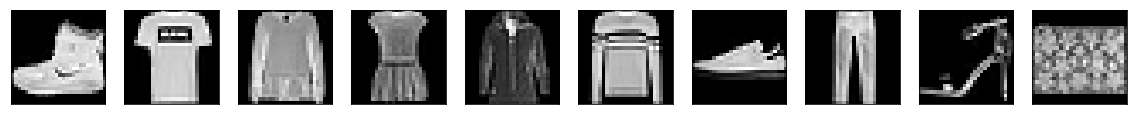

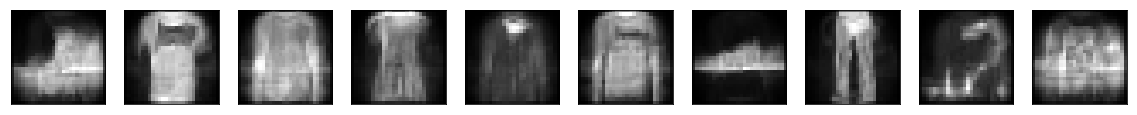

Histograms of the encodings - Sparsity (Hoyer):  0.22111380272706213


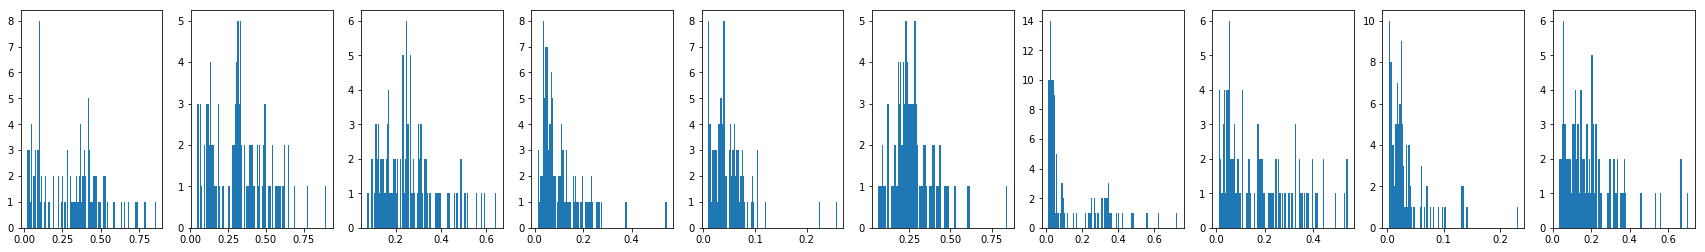

Atom images of the decoder


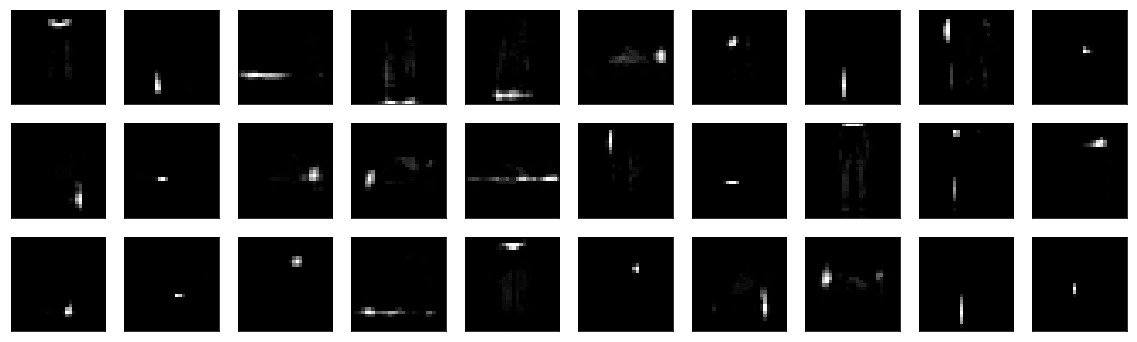

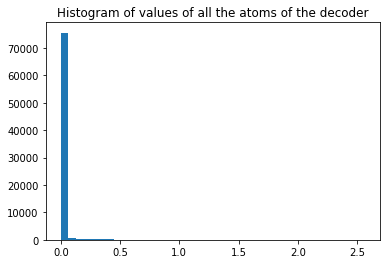

In [5]:
print('(Train) Original images and reconstructions - Reconstruction error: ', metrics.reconstruction_error(x_train, atoms, h_train))
bastien_utils.plot_all_images(x_small)
bastien_utils.plot_all_images(x_rec_small)
print('Histograms of the encodings - Sparsity (Hoyer): ', metrics.sparsity_Hoyer(h_train))
metrics.plot_histograms_of_the_encoding(h_train[idx_small])
print('Atom images of the decoder')
bastien_utils.plot_all_images(atoms[:30])
plt.hist(atoms.flatten(), bins=40)
plt.title('Histogram of values of all the atoms of the decoder')
plt.show()

Dilatation of original images


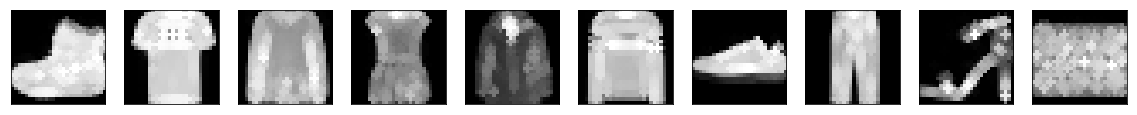

Dilatation of reconstructed images


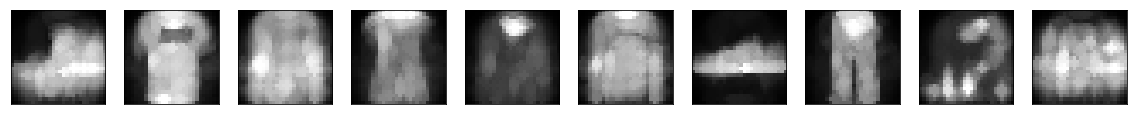

Max-approx error to original:  1.1247425726107918  - Max-approx error to reconstruction:  0.7843505021452586


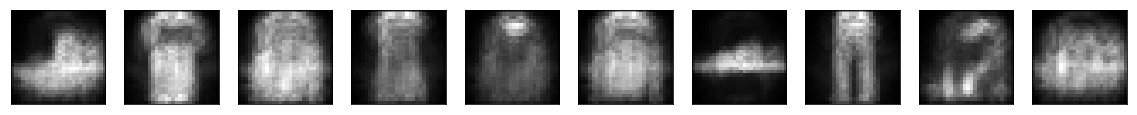

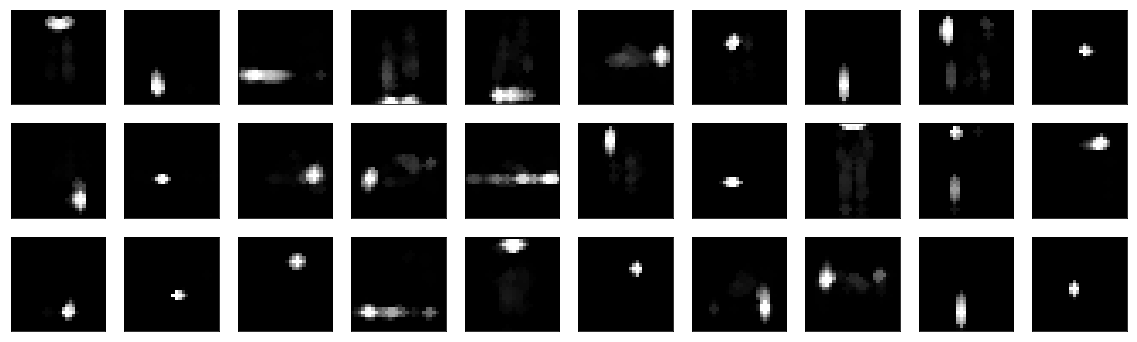

In [6]:
atoms_dil = bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, atoms, SE_scale=1)
max_approx = metrics.max_approximation_error(x_train, atoms, h_train, morphoMaths.dilatation, SE_scale=1)

print('Dilatation of original images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
print('Dilatation of reconstructed images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_rec_small, SE_scale=1))
print('Max-approx error to original: ', max_approx[0], ' - Max-approx error to reconstruction: ', max_approx[1])
bastien_utils.plot_all_images(metrics.reconstructions(atoms_dil, h_train[idx_small]))
bastien_utils.plot_all_images(atoms_dil[:30])